# IFW tests
## For publication

### Review IFW hypothesis test, make faster

In [1]:
# import necessary packages
import pandas as pd
import numpy as np
import scipy
from functools import partial
from os.path import exists
import multiprocess
import scipy.sparse
import matplotlib.pyplot as plt
from p_tqdm import p_map
import seaborn as sns

In [23]:
# change directory so that files are saved to fw_mres but not this dev file
import os

# Change the current working directory
new_directory = 'c:/Users/sergi/Documents/GitHub/fw_mres/dev_syndata/'
os.chdir(new_directory)
path = os.getcwd()
# Verify the change
print(f"Current working directory: {os.getcwd()}")

Current working directory: c:\Users\sergi\Documents\GitHub\fw_mres\dev_syndata


In [18]:
# original functions
syndata = pd.read_csv(path + "/syn_data.csv",header=0,index_col=0)

def normalise_counts(count_matrix):
    Upper = np.percentile(count_matrix,97.5,axis=0) #get upper percentile of each gene (column)
    #now for those which have 0 as the 97.5th percentile, just get the maximum value as the upper
    Upper[Upper == 0] = np.max(count_matrix,axis=0)[Upper == 0] 
    #now clip essentially makes values bigger than the Upper, the Upper limit. There is a deprecation warning for this function.
    count_matrix = count_matrix.astype(float)
    count_matrix = count_matrix.clip(upper=Upper,axis=1) #We do this for columns (for clip its 1)
    count_max = np.max(count_matrix,axis=0) #get the max, which is 97.5th percentile, to normalise
    output = count_matrix / count_max #just normalise
    return output

norm_orig = normalise_counts(count_matrix=syndata)
column_name = norm_orig.columns
Feature_IDs = column_name
def two_state_discretization(feature):
    res = np.zeros(len(feature))
    res[np.where(feature == 0)] = 0
    nonzero = feature[np.where(feature != 0)]
    #med = np.median(nonzero)
    cutoff = np.percentile(nonzero, 25)
    bins = [cutoff]
    if cutoff >= 0.95:
        nonzero_vals = np.ones(len(nonzero))
    else:
        nonzero_vals = np.digitize(nonzero, bins = bins, right = True)
    res[np.where(feature != 0)] = nonzero_vals
    return res.astype(int)

binarised_matrix = []
for i in range(len(Feature_IDs)):
    binarised_matrix.append(two_state_discretization(np.array(norm_orig.iloc[:, i])))

binarised_matrix = np.array(binarised_matrix).T
binarised_df = pd.DataFrame(data=binarised_matrix, columns=norm_orig.columns, index=norm_orig.index)
binarised_df


,0,1,2,3,4,5,6,7,8,9,...,1509,1510,1511,1512,1513,1514,1515,1516,1517,1518
0,0,1,0,1,0,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
1,0,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,1,1,0,1,1,1,1,1,...,0,0,0,0,1,0,0,1,1,0
3,0,1,1,0,1,1,1,1,0,1,...,0,0,0,0,0,1,1,0,1,0
4,0,1,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1,1,1,1,1,1,1,1,1,1,...,1,0,1,0,1,0,1,1,0,1
1196,0,1,0,1,1,0,1,1,1,1,...,1,0,0,1,1,1,1,1,1,0
1197,1,0,0,1,1,0,0,1,1,1,...,0,0,1,1,1,0,1,1,1,1
1198,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,1,1,0


<Axes: >

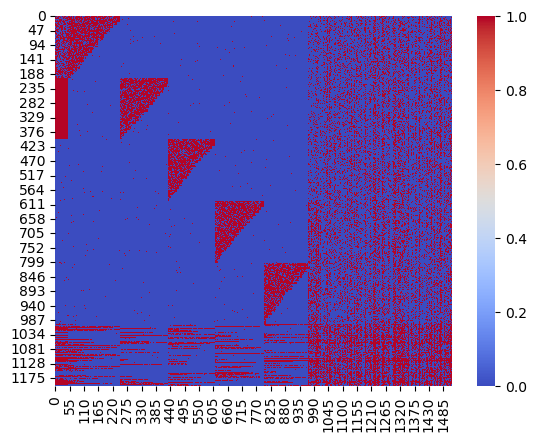

In [3]:
sns.heatmap(binarised_df, cmap="coolwarm")

<Axes: >

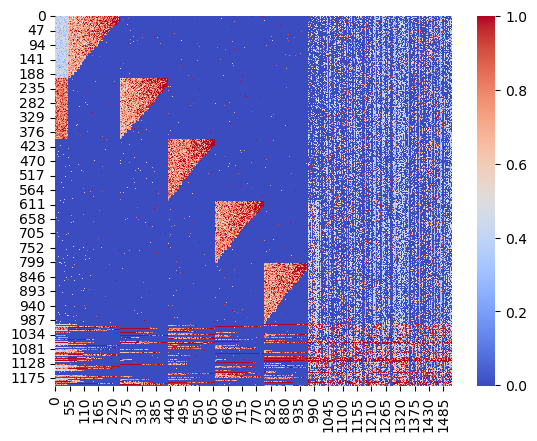

In [4]:
sns.heatmap(norm_orig, cmap="coolwarm")

similar enough, just carry on with binary - make wrapper function

In [19]:
# new binary wrapper
def preprocess_counts(count_matrix):
    Upper = np.percentile(count_matrix,97.5,axis=0) #get upper percentile of each gene (column)
    #now for those which have 0 as the 97.5th percentile, just get the maximum value as the upper
    Upper[Upper == 0] = np.max(count_matrix,axis=0)[Upper == 0] 
    #now clip essentially makes values bigger than the Upper, the Upper limit. There is a deprecation warning for this function.
    count_matrix = count_matrix.astype(float)
    count_matrix = count_matrix.clip(upper=Upper,axis=1) #We do this for columns (for clip its 1)
    count_max = np.max(count_matrix,axis=0) #get the max, which is 97.5th percentile, to normalise
    norm_orig = count_matrix / count_max #just normalise
    print(f"Normalisation done. Matrix shape is {norm_orig.shape} Now discretising.\n")
    
    # now discretisation
    def two_state_discretisation(feature):
        res = np.zeros(len(feature))
        res[np.where(feature == 0)] = 0
        nonzero = feature[np.where(feature != 0)]
        #med = np.median(nonzero)
        cutoff = np.percentile(nonzero, 25)
        bins = [cutoff]
        if cutoff >= 0.95:
            nonzero_vals = np.ones(len(nonzero))
        else:
            nonzero_vals = np.digitize(nonzero, bins = bins, right = True)
        res[np.where(feature != 0)] = nonzero_vals
        return res.astype(int)
    
    Feature_IDs = norm_orig.columns
    binarised_matrix = []
    for i in range(len(Feature_IDs)):
        binarised_matrix.append(two_state_discretisation(np.array(norm_orig.iloc[:, i])))

    print(f"Discretisation done. Returning resulting normalised and binarised matrices.\n")
    binarised_matrix = np.array(binarised_matrix).T
    binarised_df = pd.DataFrame(data=binarised_matrix, columns=Feature_IDs, index=norm_orig.index)
    
    return norm_orig, binarised_df

norm_orig, binarised_df = preprocess_counts(count_matrix=syndata)

binarised_df

Normalisation done. Matrix shape is (1200, 1519) Now discretising.

Discretisation done. Returning resulting normalised and binarised matrices.



,0,1,2,3,4,5,6,7,8,9,...,1509,1510,1511,1512,1513,1514,1515,1516,1517,1518
0,0,1,0,1,0,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
1,0,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,1,1,0,1,1,1,1,1,...,0,0,0,0,1,0,0,1,1,0
3,0,1,1,0,1,1,1,1,0,1,...,0,0,0,0,0,1,1,0,1,0
4,0,1,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1,1,1,1,1,1,1,1,1,1,...,1,0,1,0,1,0,1,1,0,1
1196,0,1,0,1,1,0,1,1,1,1,...,1,0,0,1,1,1,1,1,1,0
1197,1,0,0,1,1,0,0,1,1,1,...,0,0,1,1,1,0,1,1,1,1
1198,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,1,1,0


# Trifurcation dataset

In [24]:
# change directory so that files are saved to fw_mres but not this dev file
import os

# Change the current working directory
new_directory = 'c:/Users/sergi/Documents/GitHub/fw_mres/dev_syndata/'
os.chdir(new_directory)
path = os.getcwd()
# Verify the change
print(f"Current working directory: {os.getcwd()}")

Current working directory: c:\Users\sergi\Documents\GitHub\fw_mres\dev_syndata


In [26]:
trifdata = pd.read_csv(path +"/trif/trif_data.csv",header=0,index_col=0)
syndata = pd.read_csv(path + "/syn_data.csv",header=0,index_col=0)
trifdata

,A1_TF1,A1_TF2,A1_TF3,A1_TF4,A1_TF5,A1_TF6,A1_TF7,A1_TF8,A1_TF9,A1_TF10,...,HK1991,HK1992,HK1993,HK1994,HK1995,HK1996,HK1997,HK1998,HK1999,HK2000
cell1,1,0,0,0,2,1,3,2,2,2,...,0,0,0,0,0,0,0,0,0,0
cell2,0,2,0,0,0,2,2,2,2,2,...,0,0,0,0,0,0,1,0,0,0
cell3,3,2,0,2,0,0,3,1,1,0,...,1,0,0,0,0,0,1,0,0,0
cell4,3,1,3,1,1,1,1,2,0,4,...,0,0,0,0,0,1,0,0,0,0
cell5,1,3,1,0,2,1,2,1,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell2996,2,3,3,2,1,1,1,2,2,3,...,0,0,0,0,0,1,0,0,0,0
cell2997,1,4,1,3,0,1,1,0,0,1,...,0,1,1,0,0,0,1,0,0,1
cell2998,3,2,1,4,2,2,4,2,1,2,...,1,0,0,0,0,0,0,0,0,0
cell2999,1,3,4,2,1,0,1,1,1,1,...,0,0,0,0,0,3,0,2,0,1


Text(0.5, 1.0, 'Syndata')

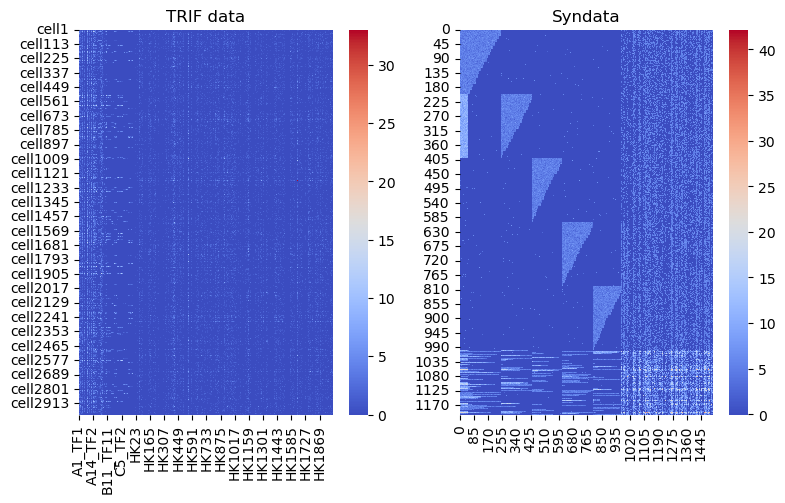

In [10]:
# Set up the subplot grid
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

sns.heatmap(trifdata, cmap="coolwarm", ax=axes[0])
axes[0].set_title(f'TRIF data')

sns.heatmap(syndata, cmap="coolwarm", ax=axes[1])
axes[1].set_title('Syndata')

In [5]:
# now preprocess
trif_norm, trif_binary = preprocess_counts(count_matrix=trifdata)
syndata_norm, syndata_binary = preprocess_counts(count_matrix=syndata)

Normalisation done. Matrix shape is (3000, 2546) Now discretising.

Discretisation done. Returning resulting normalised and binarised matrices.

Normalisation done. Matrix shape is (1200, 1519) Now discretising.

Discretisation done. Returning resulting normalised and binarised matrices.



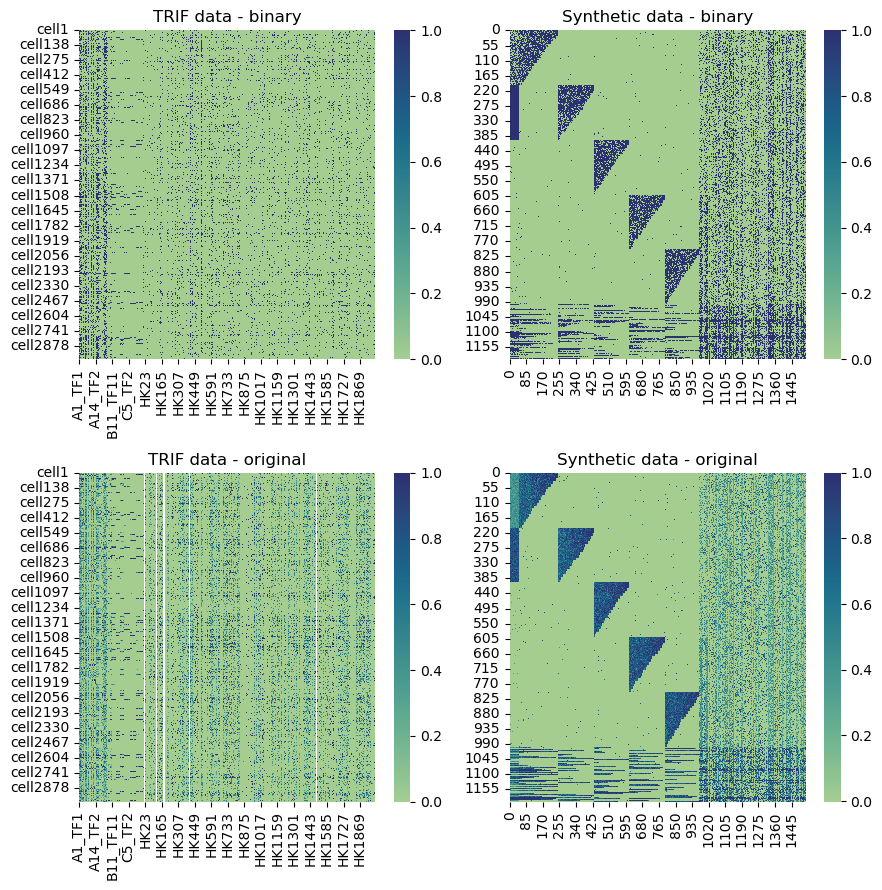

In [14]:
# Set up the subplot grid
fig, axes = plt.subplots(2, 2, figsize=(9, 9))

sns.heatmap(trif_binary, cmap="crest", ax=axes[0,0])
axes[0,0].set_title(f'TRIF data - binary')

sns.heatmap(syndata_binary, cmap="crest", ax=axes[0,1])
axes[0,1].set_title('Synthetic data - binary')

sns.heatmap(trif_norm, cmap="crest", ax=axes[1,0])
axes[1,0].set_title(f'TRIF data - original')

sns.heatmap(syndata_norm, cmap="crest", ax=axes[1,1])
axes[1,1].set_title('Synthetic data - original')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

but distributions are different...

(array([6.161498e+06, 0.000000e+00, 0.000000e+00, 9.528640e+05,
        0.000000e+00, 0.000000e+00, 2.894020e+05, 0.000000e+00,
        0.000000e+00, 1.164660e+05, 0.000000e+00, 0.000000e+00,
        5.608600e+04, 0.000000e+00, 0.000000e+00, 2.883600e+04,
        0.000000e+00, 0.000000e+00, 1.519400e+04, 0.000000e+00,
        0.000000e+00, 7.955000e+03, 0.000000e+00, 0.000000e+00,
        4.331000e+03, 0.000000e+00, 0.000000e+00, 2.512000e+03,
        0.000000e+00, 0.000000e+00, 1.297000e+03, 0.000000e+00,
        0.000000e+00, 7.130000e+02, 0.000000e+00, 0.000000e+00,
        3.630000e+02, 0.000000e+00, 0.000000e+00, 2.160000e+02,
        0.000000e+00, 0.000000e+00, 1.160000e+02, 0.000000e+00,
        0.000000e+00, 5.800000e+01, 0.000000e+00, 0.000000e+00,
        3.900000e+01, 0.000000e+00, 0.000000e+00, 1.800000e+01,
        0.000000e+00, 0.000000e+00, 1.100000e+01, 0.000000e+00,
        0.000000e+00, 8.000000e+00, 0.000000e+00, 0.000000e+00,
        9.000000e+00, 0.000000e+00, 0.00

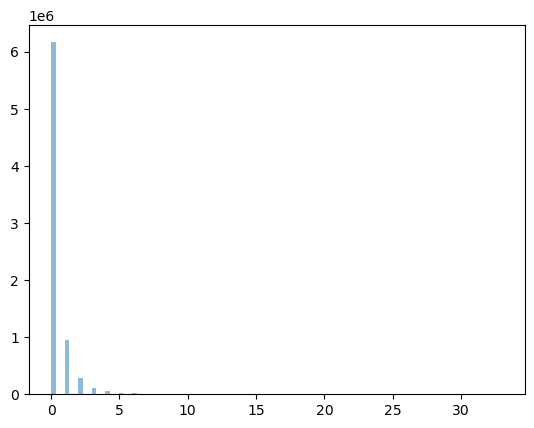

In [15]:
plt.hist(trifdata.values.flatten(), bins=100, alpha=0.5, label='TRIF')

(array([1.36703e+06, 5.00000e+00, 3.50000e+01, 1.50000e+02, 5.60000e+02,
        1.87600e+03, 5.30800e+03, 1.27870e+04, 2.46450e+04, 4.09870e+04,
        5.69730e+04, 6.67650e+04, 6.52980e+04, 5.36880e+04, 3.72760e+04,
        2.16230e+04, 1.11000e+04, 5.17800e+03, 2.89900e+03, 2.56800e+03,
        3.27700e+03, 4.06200e+03, 4.56500e+03, 4.98700e+03, 4.86300e+03,
        4.37300e+03, 3.57200e+03, 2.73900e+03, 1.98200e+03, 1.37100e+03,
        9.62000e+02, 7.84000e+02, 6.08000e+02, 6.20000e+02, 7.23000e+02,
        6.91000e+02, 6.53000e+02, 6.16000e+02, 5.68000e+02, 4.84000e+02,
        4.00000e+02, 2.98000e+02, 2.48000e+02, 2.37000e+02, 2.06000e+02,
        1.91000e+02, 1.55000e+02, 1.86000e+02, 1.60000e+02, 1.63000e+02,
        1.28000e+02, 1.39000e+02, 1.12000e+02, 7.80000e+01, 6.70000e+01,
        6.00000e+01, 6.40000e+01, 6.20000e+01, 4.80000e+01, 5.80000e+01,
        6.00000e+01, 4.60000e+01, 3.50000e+01, 3.40000e+01, 4.20000e+01,
        2.50000e+01, 2.70000e+01, 2.50000e+01, 1.50

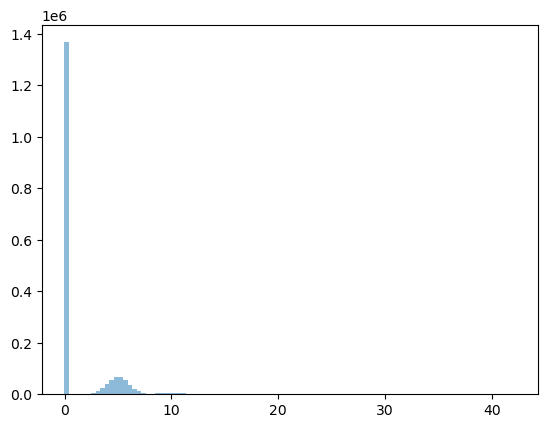

In [16]:
plt.hist(syndata.values.flatten(), bins=100, alpha=0.5, label='TRIF')

try with standard discretisation first

In [19]:
# obtain indices of upper triangular matrix
def triu_list(n):
    triu_indices = np.triu_indices(n, k=1)  # k=1 excludes diagonal
    triu = []
    for f in np.unique(triu_indices[0]):
        l = triu_indices[1][triu_indices[0] == f]
        triu.append([f,l])
    return triu, triu_indices

In [7]:
# now do chisq test with indices of upper triangular matrix
def test_binarised_chisq(feature_ind, triu, binarised_df):
    import numpy as np
    import scipy
    
    triu_ind = [feat[1] for feat in triu if feat[0] == feature_ind][0]
    f1 = np.array(binarised_df.iloc[:,feature_ind])
    chip = []
    chistat = []
    
    for i in triu_ind:
        #define feature 2
        f2 = np.array(binarised_df.iloc[:,i])
        if len(f1) != len(f2):
            print("Fixed feature and features from matrix must be of the same length (same n of cells).")
        # get number of counts
        else:
            n00 = 0
            n01 = 0
            n10 = 0
            n11 = 0
            for (cell1, cell2) in zip(f1, f2):
                if cell1 == cell2:
                    if cell1 == 0:
                        n00 += 1
                    elif cell1 == 1:
                        n11 += 1
                        
                elif cell1 == 0:
                    if cell2 == 1:
                        n01 += 1
                        
                elif cell1 == 1:
                    if cell2 == 0:
                        n10 += 1
                        
            allns = [n11, n10, n01, n00]
            n_by_ind = np.array(allns) #.T
            C = binarised_df.shape[0]

            p_11 = ((n11 + n10)/C) * ((n11 + n01)/C)
            p_10 = ((n11 + n10)/C) * (1 - (n11 + n01)/C)
            p_01 = (1 - (n11 + n10)/C) * ((n11 + n01)/C)
            p_00 = (1 - (n11 + n10)/C) * (1 - (n11 + n01)/C)
            probs = [p_11,p_10,p_01,p_00]
            probs_byind = np.array(probs) #.T

            #total = []
            #freq = []

            total = np.sum(n_by_ind) # should just be number of cells
            freq = probs_byind * total

            chip.append(scipy.stats.chisquare(n_by_ind, f_exp=freq).pvalue)
            chistat.append(scipy.stats.chisquare(n_by_ind, f_exp=freq).statistic)
                
    return [chip, chistat]

In [8]:
def Parallel_Calculate_chisq(binarised_data, Use_Cores=-1):
    ## Identify number of cores to use.
    import numpy as np
    global binarised_dataset
    binarised_dataset = binarised_data
    print(f"Data loaded. Shape: {binarised_dataset.shape}. Proceeding to obtain indices for efficient significance testing.\n")
    ## Provide indices for parallel computing and efficiency
    n = binarised_dataset.shape[1]
    def triu_list(n):
        triu_indices = np.triu_indices(n, k=1)  # k=1 excludes diagonal
        triu = []
        for f in np.unique(triu_indices[0]):
            l = triu_indices[1][triu_indices[0] == f]
            triu.append([f,l])
        return triu, triu_indices
    triu, triu_indices = triu_list(n)
    Feature_Inds = [feat[0] for feat in triu]
    print(f"Indices obtained. Proceeding with performing statistical tests in parallel.\n")
    
    Cores_Available = multiprocess.cpu_count()
    print("Cores Available: " + str(Cores_Available))
    if Use_Cores == -1:
        Use_Cores = Cores_Available - 1 # -1 Is an arbitrary buffer of idle cores that I set.
        if Use_Cores < 1:
            Use_Cores = 1
    print("Cores Used: " + str(Use_Cores))
    ## Perform calculations
    with np.errstate(divide='ignore',invalid='ignore'):
        chisq = p_map(partial(test_binarised_chisq, binarised_df=binarised_dataset, triu=triu), Feature_Inds, num_cpus=Use_Cores)
    chip = [row[0] for row in chisq]
    
    print(f"Calculations complete. Reconstructing significance matrix.\n")
    # Use allscores to build square matrix
    indices = (triu_indices[0], triu_indices[1])
    values = [value for sublist in chip for value in sublist]
    # Initialize a zero matrix
    matrix = np.zeros((n, n), dtype=float)
    for row, col, value in zip(indices[0], indices[1], values):
        #print(f"Placing value {value} at position ({row}, {col})")  # Debug print
        matrix[row, col] = value

    print("Matrix construction complete. Saving to dataframe.")
    m = pd.DataFrame(matrix)
    chip_m = m + m.T - np.diag(np.diag(m)) # make square
    return chisq, chip_m

In [9]:
trif_chisq, trif_chip_m = Parallel_Calculate_chisq(binarised_data=trif_binary, Use_Cores=3)

Data loaded. Shape: (3000, 2546). Proceeding to obtain indices for efficient significance testing.

Indices obtained. Proceeding with performing statistical tests in parallel.

Cores Available: 8
Cores Used: 3


  0%|          | 0/2545 [00:00<?, ?it/s]

Calculations complete. Reconstructing significance matrix.

Matrix construction complete. Saving to dataframe.


In [10]:
trif_chip_m

,0,1,2,3,4,5,6,7,8,9,...,2536,2537,2538,2539,2540,2541,2542,2543,2544,2545
0,0.000000e+00,1.370152e-06,1.004954e-04,2.370910e-08,3.091715e-08,2.109121e-07,5.620852e-07,1.161672e-04,1.675482e-07,2.222394e-05,...,0.570387,0.940253,0.996989,0.973195,0.634863,0.999986,0.991026,0.901534,0.999932,0.912924
1,1.370152e-06,0.000000e+00,7.565771e-11,1.173378e-07,3.893638e-10,2.526843e-07,1.368088e-07,2.070202e-09,5.620043e-05,3.276329e-06,...,0.687338,0.924121,0.682286,0.999895,0.532988,0.747131,0.320358,0.520454,0.547334,0.954382
2,1.004954e-04,7.565771e-11,0.000000e+00,6.764438e-04,9.766835e-13,2.798750e-08,7.445132e-05,1.429844e-12,1.917794e-12,1.773664e-06,...,0.714258,0.920573,0.964609,0.212415,0.999942,0.700064,0.999246,0.545151,0.967587,0.730207
3,2.370910e-08,1.173378e-07,6.764438e-04,0.000000e+00,3.755720e-04,1.891913e-09,2.712757e-04,7.133035e-09,6.847161e-09,9.264362e-07,...,0.924953,0.898552,0.973068,0.997249,0.965489,0.605097,0.983184,0.823904,0.886298,0.690735
4,3.091715e-08,3.893638e-10,9.766835e-13,3.755720e-04,0.000000e+00,1.451589e-08,9.626290e-11,1.108077e-07,5.380017e-10,6.665693e-12,...,0.884559,0.986128,0.888028,0.996138,0.970754,0.278098,0.276318,0.753613,0.843688,0.999971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2541,9.999863e-01,7.471309e-01,7.000635e-01,6.050968e-01,2.780981e-01,7.802561e-01,8.704662e-01,9.838202e-01,8.860428e-01,9.999733e-01,...,0.000081,0.004266,0.140143,0.954249,0.999537,0.000000,0.002389,0.002146,0.000099,0.000246
2542,9.910261e-01,3.203582e-01,9.992463e-01,9.831839e-01,2.763178e-01,1.146683e-01,1.774774e-01,9.756206e-01,2.391012e-02,9.979647e-01,...,0.005770,0.169512,0.197043,0.799015,0.876100,0.002389,0.000000,0.784593,0.000135,0.874305
2543,9.015339e-01,5.204537e-01,5.451515e-01,8.239039e-01,7.536127e-01,7.124520e-01,9.441764e-01,9.899612e-01,6.544485e-01,4.542892e-01,...,0.110930,0.236592,0.103443,0.283569,0.921853,0.002146,0.784593,0.000000,0.000472,0.406949
2544,9.999316e-01,5.473341e-01,9.675873e-01,8.862984e-01,8.436878e-01,8.851544e-01,9.812526e-01,9.988898e-01,9.728929e-01,1.781691e-01,...,0.051572,0.874528,0.007701,0.679355,0.888990,0.000099,0.000135,0.000472,0.000000,0.228339


In [14]:
trif_chip_m.to_csv('trif_bIFW_chip.csv')

now mask matrix using thresholding - see the heatmap...

<Axes: >

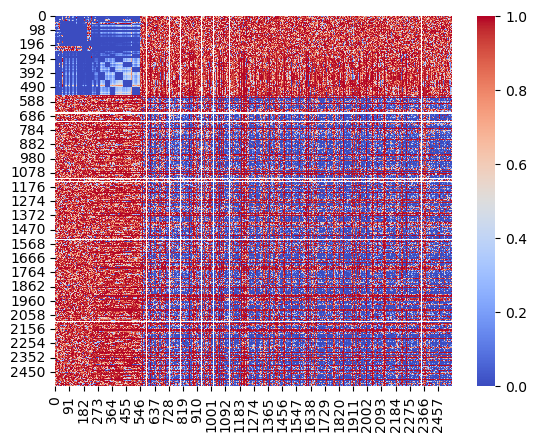

In [15]:
sns.heatmap(trif_chip_m, cmap="coolwarm")

In [32]:
trif_chip_m = pd.read_csv("trif_bIFW_chip.csv",header=0,index_col=0)
trif_chip_m

,0,1,2,3,4,5,6,7,8,9,...,2536,2537,2538,2539,2540,2541,2542,2543,2544,2545
0,0.000000e+00,1.370152e-06,1.004954e-04,2.370910e-08,3.091715e-08,2.109121e-07,5.620852e-07,1.161672e-04,1.675482e-07,2.222394e-05,...,0.570387,0.940253,0.996989,0.973195,0.634863,0.999986,0.991026,0.901534,0.999932,0.912924
1,1.370152e-06,0.000000e+00,7.565771e-11,1.173378e-07,3.893638e-10,2.526843e-07,1.368088e-07,2.070202e-09,5.620043e-05,3.276329e-06,...,0.687338,0.924121,0.682286,0.999895,0.532988,0.747131,0.320358,0.520454,0.547334,0.954382
2,1.004954e-04,7.565771e-11,0.000000e+00,6.764438e-04,9.766835e-13,2.798750e-08,7.445132e-05,1.429844e-12,1.917794e-12,1.773664e-06,...,0.714258,0.920573,0.964609,0.212415,0.999942,0.700064,0.999246,0.545151,0.967587,0.730207
3,2.370910e-08,1.173378e-07,6.764438e-04,0.000000e+00,3.755720e-04,1.891913e-09,2.712757e-04,7.133035e-09,6.847161e-09,9.264362e-07,...,0.924953,0.898552,0.973068,0.997249,0.965489,0.605097,0.983184,0.823904,0.886298,0.690735
4,3.091715e-08,3.893638e-10,9.766835e-13,3.755720e-04,0.000000e+00,1.451589e-08,9.626290e-11,1.108077e-07,5.380017e-10,6.665693e-12,...,0.884559,0.986128,0.888028,0.996138,0.970754,0.278098,0.276318,0.753613,0.843688,0.999971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2541,9.999863e-01,7.471309e-01,7.000635e-01,6.050968e-01,2.780981e-01,7.802561e-01,8.704662e-01,9.838202e-01,8.860428e-01,9.999733e-01,...,0.000081,0.004266,0.140143,0.954249,0.999537,0.000000,0.002389,0.002146,0.000099,0.000246
2542,9.910261e-01,3.203582e-01,9.992463e-01,9.831839e-01,2.763178e-01,1.146683e-01,1.774774e-01,9.756206e-01,2.391012e-02,9.979647e-01,...,0.005770,0.169512,0.197043,0.799015,0.876100,0.002389,0.000000,0.784593,0.000135,0.874305
2543,9.015339e-01,5.204537e-01,5.451515e-01,8.239039e-01,7.536127e-01,7.124520e-01,9.441764e-01,9.899612e-01,6.544485e-01,4.542892e-01,...,0.110930,0.236592,0.103443,0.283569,0.921853,0.002146,0.784593,0.000000,0.000472,0.406949
2544,9.999316e-01,5.473341e-01,9.675873e-01,8.862984e-01,8.436878e-01,8.851544e-01,9.812526e-01,9.988898e-01,9.728929e-01,1.781691e-01,...,0.051572,0.874528,0.007701,0.679355,0.888990,0.000099,0.000135,0.000472,0.000000,0.228339


In [38]:
trif_chip_m

,0,1,2,3,4,5,6,7,8,9,...,2536,2537,2538,2539,2540,2541,2542,2543,2544,2545
0,0.000000e+00,1.370152e-06,1.004954e-04,2.370910e-08,3.091715e-08,2.109121e-07,5.620852e-07,1.161672e-04,1.675482e-07,2.222394e-05,...,0.570387,0.940253,0.996989,0.973195,0.634863,0.999986,0.991026,0.901534,0.999932,0.912924
1,1.370152e-06,0.000000e+00,7.565771e-11,1.173378e-07,3.893638e-10,2.526843e-07,1.368088e-07,2.070202e-09,5.620043e-05,3.276329e-06,...,0.687338,0.924121,0.682286,0.999895,0.532988,0.747131,0.320358,0.520454,0.547334,0.954382
2,1.004954e-04,7.565771e-11,0.000000e+00,6.764438e-04,9.766835e-13,2.798750e-08,7.445132e-05,1.429844e-12,1.917794e-12,1.773664e-06,...,0.714258,0.920573,0.964609,0.212415,0.999942,0.700064,0.999246,0.545151,0.967587,0.730207
3,2.370910e-08,1.173378e-07,6.764438e-04,0.000000e+00,3.755720e-04,1.891913e-09,2.712757e-04,7.133035e-09,6.847161e-09,9.264362e-07,...,0.924953,0.898552,0.973068,0.997249,0.965489,0.605097,0.983184,0.823904,0.886298,0.690735
4,3.091715e-08,3.893638e-10,9.766835e-13,3.755720e-04,0.000000e+00,1.451589e-08,9.626290e-11,1.108077e-07,5.380017e-10,6.665693e-12,...,0.884559,0.986128,0.888028,0.996138,0.970754,0.278098,0.276318,0.753613,0.843688,0.999971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2541,9.999863e-01,7.471309e-01,7.000635e-01,6.050968e-01,2.780981e-01,7.802561e-01,8.704662e-01,9.838202e-01,8.860428e-01,9.999733e-01,...,0.000081,0.004266,0.140143,0.954249,0.999537,0.000000,0.002389,0.002146,0.000099,0.000246
2542,9.910261e-01,3.203582e-01,9.992463e-01,9.831839e-01,2.763178e-01,1.146683e-01,1.774774e-01,9.756206e-01,2.391012e-02,9.979647e-01,...,0.005770,0.169512,0.197043,0.799015,0.876100,0.002389,0.000000,0.784593,0.000135,0.874305
2543,9.015339e-01,5.204537e-01,5.451515e-01,8.239039e-01,7.536127e-01,7.124520e-01,9.441764e-01,9.899612e-01,6.544485e-01,4.542892e-01,...,0.110930,0.236592,0.103443,0.283569,0.921853,0.002146,0.784593,0.000000,0.000472,0.406949
2544,9.999316e-01,5.473341e-01,9.675873e-01,8.862984e-01,8.436878e-01,8.851544e-01,9.812526e-01,9.988898e-01,9.728929e-01,1.781691e-01,...,0.051572,0.874528,0.007701,0.679355,0.888990,0.000099,0.000135,0.000472,0.000000,0.228339


In [37]:
def mask_non_sig(sign_matrix, threshold=0.05, bonferroni=True):
    n = sign_matrix.shape[0]
    np.fill_diagonal(sign_matrix.to_numpy(), 0)
    t_sign_matrix = np.absolute(sign_matrix)
    #avoid log(0) by setting a cutoff
    cutoff = 1e-300
    t_sign_matrix[t_sign_matrix < cutoff] = 0
    t_sign_matrix[t_sign_matrix > cutoff] = -np.log(t_sign_matrix[t_sign_matrix > cutoff])
    if bonferroni == True:
        corrected_thr = -np.log(threshold/(n*n))
        print(f"Bonferroni-corrected -log(p) threshold is {corrected_thr}, and the p-value is {threshold/(n*n)}")
    else:
        corrected_thr = -np.log(threshold)
        print(f"Non-corrected -log(p) threshold is {corrected_thr}, and the p-value is {threshold}")
    t_sign_matrix[t_sign_matrix < corrected_thr] = 0
    np.fill_diagonal(t_sign_matrix.to_numpy(), 0) #remove inf values...
    return t_sign_matrix

trif_chip_m_masked = mask_non_sig(trif_chip_m, threshold=0.05)
trif_chip_m_masked

Bonferroni-corrected -log(p) threshold is 18.680289831788695, and the p-value is 7.713530581680427e-09


,0,1,2,3,4,5,6,7,8,9,...,2536,2537,2538,2539,2540,2541,2542,2543,2544,2545
0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,23.304802,0.0,21.666507,0.000000,0.000000,19.995620,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,23.304802,0.000000,0.0,27.654614,0.000000,0.000000,27.273456,26.979846,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.000000,0.0,0.000000,20.085677,0.000000,18.758529,18.799432,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,21.666507,27.654614,0.0,0.000000,0.000000,23.063938,0.000000,21.343159,25.734047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2541,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2542,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2543,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2544,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:
print(f"The number of nan values is {np.sum(np.isnan(trif_chip_m_masked.values))} out of {2546*2546} total values or.")

The number of nan values is 336608 out of 6482116 total values.


In [119]:
print(f"The number of nan values is {np.sum(np.isnan(trif_chip_m.values))} out of {2546*2546} total values.")

The number of nan values is 336608 out of 6482116 total values.


<Axes: >

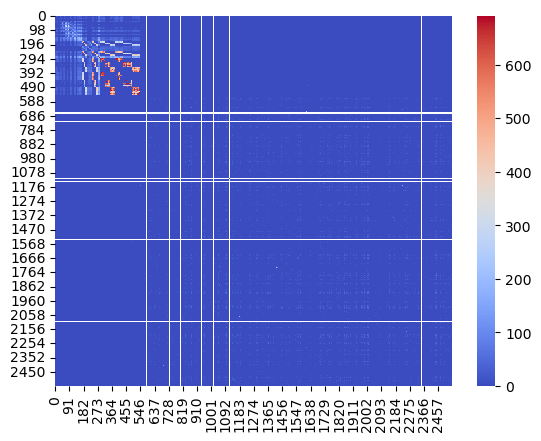

In [39]:
sns.heatmap(trif_chip_m_masked, cmap="coolwarm")

In [41]:
print(f"The maximum value in the matrix is: {trif_chip_m_masked.max().max()} and the minimum value is: {trif_chip_m_masked.min().min()}")

The maximum value in the matrix is: 690.7508421412539 and the minimum value is: 0.0


<Axes: >

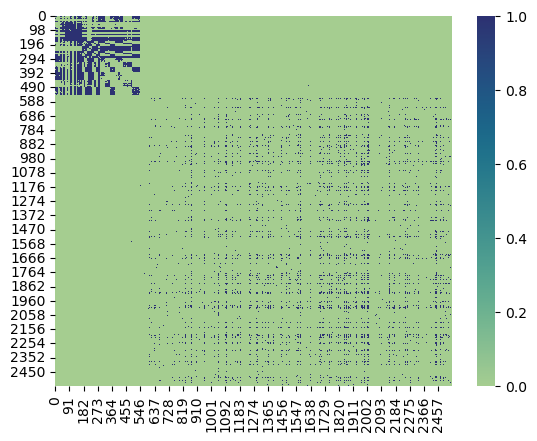

In [43]:
# binarise it
trif_chip_m_masked_bin = np.where(trif_chip_m_masked > 0, 1, 0)
sns.heatmap(trif_chip_m_masked_bin, cmap="crest")

### Now calculate ESS for the significant ones

In [46]:
# ESS new
def two_state_custom_ESS(feature_ind, sign_comp, normalised_matrix, extra_vectors = False, zero_info = True, extra_info = False):
    import numpy as np
    import scipy
    # get the list of significant features
    sign_list = [feat[1] for feat in sign_comp if feat[0] == feature_ind][0]
    MI_vector = []
    S_q_vector = []
    S_m_vector = []
    #direction_vector = []
    f1 = np.array(normalised_matrix.iloc[:,feature_ind])
    
    for i in sign_list:
        
        # print("Calculating MI for feature number", i)
        
        #define feature 2
        f2 = np.array(normalised_matrix.iloc[:,i])
        
        n00 = 0
        n01 = 0
        n10 = 0
        n11 = 0
        
        # get number of counts
        
        if len(f1) != len(f2):
            print("Fixed feature and features from matrix must be of the same length (same n of cells).")
        
        else:
            c = len(f1)
            for (cell1, cell2) in zip(f1, f2):
                if cell1 == cell2:
                    if cell1 == 0:
                        n00 += 1
                    elif cell1 == 1:
                        n11 += 1
                        
                elif cell1 == 0:
                    if cell2 == 1:
                        n01 += 1
                        
                elif cell1 == 1:
                    if cell2 == 0:
                        n10 += 1
                        
     
        # check discretization
        ns = np.array([n00, n01, n10, n11])
        n_str = ["n00", "n01", "n10", "n11"]
        nsum = np.sum(ns)
        if nsum != c:
            print("Sum of state counts do not add up.")
            MI = np.nan
            S_q = np.nan
            S_m = np.nan
            #direction = np.nan
            
        #calculate c's - need to have at least one of each!
        else:
            #wrt to f1
            c_m0 = n00 + n01
            c_m1 = n10 + n11
            #wrt to f2
            c_q0 = n00 + n10
            c_q1 = n01 + n11
            
            cs_MI = np.array([[c_m0, c_q0], [c_m0, c_q1],
                              [c_m1, c_q0], [c_m1, c_q1]])
            
            cs_S = np.array([[c_m0, c_m1],
                             [c_q0, c_q1]])
            
           # x_max = (c_m1 * c_q1) / c
            
            MI_terms = []
           
            zeroterms = []
            for ind, n in enumerate(ns):
                if n != 0 & np.all(cs_MI[ind]) == False: #if n and both cs are nonzero, calculate
                    MI_term = (n/c * np.log2(c * n / (cs_MI[ind][0] * cs_MI[ind][1])))
                    MI_terms.append(MI_term)
                    
                else:
                    zeroterms.append(n_str[ind])
            MI = np.sum(MI_terms)
            
            # entropies separately...
            S_m_terms = []
            S_q_terms = []
            
            for ind in range(len(cs_S)):
                S_m_terms.append(cs_S[0][ind]/c * np.log2(cs_S[0][ind]/c))
                S_q_terms.append(cs_S[1][ind]/c * np.log2(cs_S[1][ind]/c))
                
            S_m = np.sum(S_m_terms) * (-1)
            S_q = np.sum(S_q_terms) * (-1)

            #direction = np.sign(n11 - x_max)

            if extra_info == True:     
                exclude = str()
                for t in zeroterms:
                    exclude += (t + ", ")
                print("Be aware that the counts " + exclude + "were 0. This affects the calculations.")
                
        MI_vector.append(MI)
        #direction_vector.append(direction)
        S_q_vector.append(S_q)
        S_m_vector.append(S_m)
    
    max_entropy = [max(Sm, Sq) for Sm, Sq in zip(S_m_vector, S_q_vector)]
    
    #now calculate ESS
    if len(MI_vector) != len(max_entropy):
        raise ValueError("All vectors (MI, x_max, S_q and S_m) must have the same length")    

    ESS_vector = np.array(MI_vector) / np.array(max_entropy)
    if extra_vectors == True:
        return [ESS_vector, MI_vector, max_entropy]            
    else:
        return [ESS_vector]

In [48]:
# new parallelised
#nonzero = np.nonzero(trif_chip_m_masked.to_numpy()) # or whatever the significance matrix is

def Parallel_Calculate_ESS(binarised_data, sign_matrix, Use_Cores=-1):
    
    global binarised_dataset
    binarised_dataset = binarised_data
    print(f"Data loaded. Shape: {binarised_dataset.shape}. Proceeding to obtain indices for efficient ESS calculation.\n")
    nonzero = np.nonzero(sign_matrix.to_numpy())
    sign_comp = []
    for f in np.unique(nonzero[0]):
        #print(f"Gene {f} has a significant interaction with genes {nonzero[1][nonzero[0] == f]}")
        l = nonzero[1][nonzero[0] == f]
        sign_comp.append([f,l])
        #print(f"Gene {f} has a significant interaction with {len(l)} genes")
    Feature_Inds = [feat[0] for feat in sign_comp]
    print(f"Indices obtained. Proceeding with calculating ESSs in parallel.\n")
    
    ## Identify number of cores to use.
    Cores_Available = multiprocess.cpu_count()
    print("Cores Available: " + str(Cores_Available))
    if Use_Cores == -1:
        Use_Cores = Cores_Available - 1 # -1 Is an arbitrary buffer of idle cores that I set.
        if Use_Cores < 1:
            Use_Cores = 1
    print("Cores Used: " + str(Use_Cores))
    ## Perform calculations
    with np.errstate(divide='ignore',invalid='ignore'):
        allscores = p_map(partial(two_state_custom_ESS, sign_comp=sign_comp, normalised_matrix=binarised_dataset), Feature_Inds, num_cpus=Use_Cores)
    print(f"Calculations complete. Proceeding with matrix reconstruction.\n")
    ESS = [row[0] for row in allscores]
    
    # Use allscores to build square matrix
    n = binarised_dataset.shape[1]
    indices = (nonzero[0], nonzero[1])
    values = [value for sublist in ESS for value in sublist]
    # Initialize a zero matrix
    matrix = np.zeros((n, n), dtype=float)
    for row, col, value in zip(indices[0], indices[1], values):
        #print(f"Placing value {value} at position ({row}, {col})")  # Debug print
        matrix[row, col] = value
    
    print("Matrix construction complete. Saving to dataframe.")
    m = pd.DataFrame(matrix)
    return allscores, m


In [49]:
trif_scores, trifESS_m = Parallel_Calculate_ESS(binarised_data=trif_binary, sign_matrix=trif_chip_m_masked, Use_Cores=3)


Data loaded. Shape: (3000, 2546). Proceeding to obtain indices for efficient ESS calculation.

Indices obtained. Proceeding with calculating ESSs in parallel.

Cores Available: 8
Cores Used: 3


  0%|          | 0/2546 [00:00<?, ?it/s]

Calculations complete. Proceeding with matrix reconstruction.

Matrix construction complete. Saving to dataframe.


In [63]:
trifESS_m.to_csv('trif_bIFW_ESS.csv')

<Axes: >

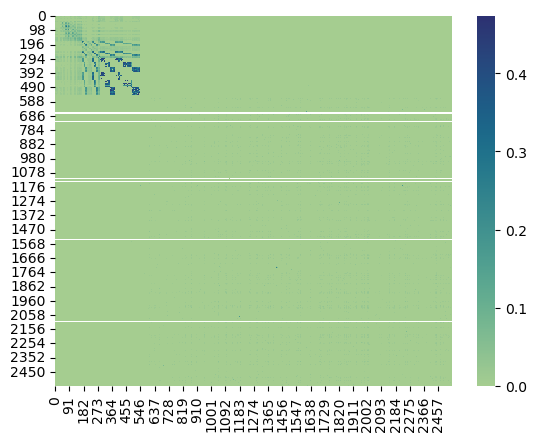

In [62]:
sns.heatmap(trifESS_m, cmap="crest")

<Axes: >

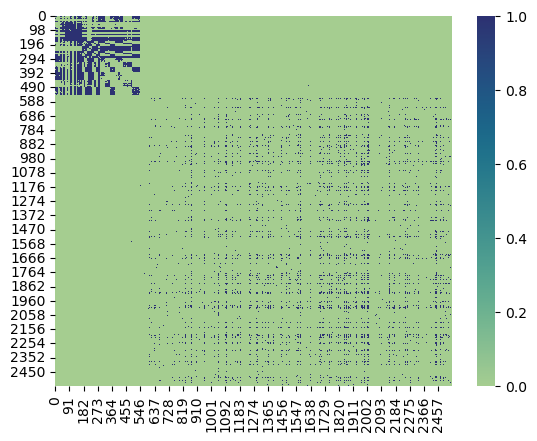

In [60]:
# binarise it
trifESS_m_bin = np.where(trifESS_m > 0, 1, 0)
sns.heatmap(trifESS_m_bin, cmap="crest")
# same as before, simply the positive p-values

## Now get weights, sort, and try to obtain AUROC curves
There are nan values in the significance matrix - however we can simply ignore them for now, it is likely that they are due to the discretisation method.

In [115]:
num_nan_values = np.sum(np.isnan(trif_chip_m_masked.iloc[14].values))
print(f"Number of NaN values in arr14: {num_nan_values}")

Number of NaN values in arr14: 67


In [120]:
def weights_IFW(masked_omega, masked_sign_matrix, normalise_by_edges = False):
    w = np.zeros(masked_omega.shape[1])
    for i in range(masked_omega.shape[0]):
        wsum = np.sum(masked_sign_matrix.iloc[i])
        prod = masked_omega.iloc[i].values * masked_sign_matrix.iloc[i].values
        if wsum > 0:
            w[i] = np.nansum(prod) / wsum
        else:
            w[i] = 0
            
    #w = np.average(masked_omega,weights=masked_sign_matrix,axis=0)
    if normalise_by_edges == True:
        edges = (masked_sign_matrix > 0).sum(1)
        n_w = w/edges
        return np.array(w), np.array(n_w), np.array(edges)
    else:
        return w
    
trif_weights = weights_IFW(trifESS_m, trif_chip_m_masked)


In [121]:
trif_weights.max().max()

0.35543768591708025

(array([1837.,  202.,   84.,   57.,   40.,   33.,   42.,   74.,  160.,
          17.]),
 array([0.        , 0.03554377, 0.07108754, 0.10663131, 0.14217507,
        0.17771884, 0.21326261, 0.24880638, 0.28435015, 0.31989392,
        0.35543769]),
 <BarContainer object of 10 artists>)

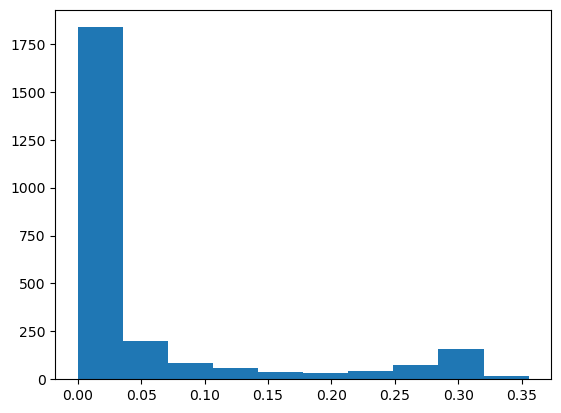

In [122]:
plt.hist(trif_weights)

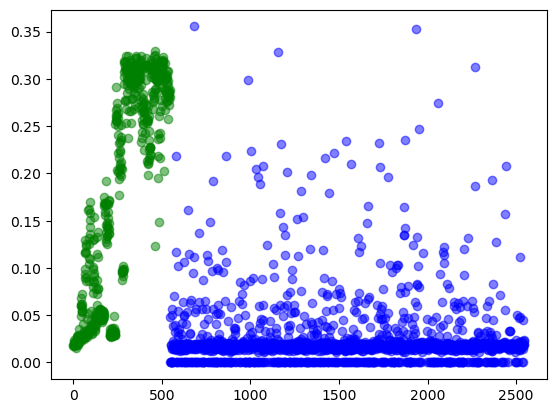

In [123]:
geneIDs = np.arange(2546)
plt.scatter(geneIDs[0:546], trif_weights[0:546], c='green', alpha=0.5)
plt.scatter(geneIDs[547:2546], trif_weights[547:2546], c='blue', alpha=0.5)
plt.show()

See if we can get the FPRs and FNRs

In [129]:
# load files
Structured_Genes = np.where(trifdata.columns.str.contains("TF"))[0]
House_Keeping_Genes = np.where(trifdata.columns.str.contains("HK"))[0]
SCRAN_HVG_Order = np.asarray(pd.read_csv("trif/scran_trif_data.csv",header=0,index_col=0)).T[0]
Seurat_HVG_Order = np.asarray(pd.read_csv("trif/seurat_trif_data.csv",header=0,index_col=0)).T[0]

In [131]:
# get bIFW ranked genes
bIFW_rank = np.argsort(-trif_weights)
bIFW_rank

array([ 682, 1936,  462, ..., 2290,  884, 1189], dtype=int64)

In [130]:
SCRAN_HVG_Order

array([282, 276, 279, ...,  13,  20,  10], dtype=int64)

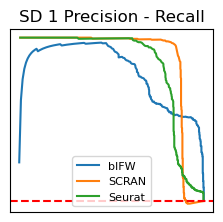

In [135]:
# compare weights
def integrate(x, y):
    area = np.trapz(y=y, x=x)
    return area

## Calculate the Precision, Recall and False Positive Rates (FPRs), along each ranked list of genes.
Spacing = np.floor(np.linspace(0,bIFW_rank.shape[0],500)).astype("i")
Spacing = np.delete(Spacing,0)
Precisions = np.zeros((3,Spacing.shape[0]))
Recalls = np.zeros((3,Spacing.shape[0]))
FPRs = np.zeros((3,Spacing.shape[0]))
for i in np.arange(Spacing.shape[0]):
    Top_Genes = bIFW_rank[np.arange(Spacing[i])]
    Captured = np.sum(np.isin(Structured_Genes,Top_Genes))
    Precisions[0,i] = Captured/Top_Genes.shape[0]
    Recalls[0,i] = Captured/Structured_Genes.shape[0]
    FPs = np.sum(np.isin(House_Keeping_Genes,Top_Genes))
    TNs = np.sum(np.isin(House_Keeping_Genes,Top_Genes)==0)
    FPRs[0,i] = FPs/(FPs+TNs)
    #
    Top_Genes = SCRAN_HVG_Order[np.arange(Spacing[i])]
    Captured = np.sum(np.isin(Structured_Genes,Top_Genes))
    Precisions[1,i] = Captured/Top_Genes.shape[0]
    Recalls[1,i] = Captured/Structured_Genes.shape[0]
    FPs = np.sum(np.isin(House_Keeping_Genes,Top_Genes))
    TNs = np.sum(np.isin(House_Keeping_Genes,Top_Genes)==0)
    FPRs[1,i] = FPs/(FPs+TNs)
    #
    Top_Genes = Seurat_HVG_Order[np.arange(Spacing[i])]
    Captured = np.sum(np.isin(Structured_Genes,Top_Genes))
    Precisions[2,i] = Captured/Top_Genes.shape[0]
    Recalls[2,i] = Captured/Structured_Genes.shape[0]
    FPs = np.sum(np.isin(House_Keeping_Genes,Top_Genes))
    TNs = np.sum(np.isin(House_Keeping_Genes,Top_Genes)==0)
    FPRs[2,i] = FPs/(FPs+TNs)


## Plot the Precision - Recall curves
bIFW_AUC = np.round(integrate(Recalls[0,:],Precisions[0,:]),3)
SCRAN_AUC = np.round(integrate(Recalls[1,:],Precisions[1,:]),3)
Seurat_AUC = np.round(integrate(Recalls[2,:],Precisions[2,:]),3)

plt.figure(figsize=(2.33,2.33))
plt.title("SD 1 Precision - Recall",fontsize=12)
plt.plot(Recalls[0,:],Precisions[0,:],label="bIFW")
plt.plot(Recalls[1,:],Precisions[1,:],label="SCRAN")
plt.plot(Recalls[2,:],Precisions[2,:],label="Seurat")
plt.axhline((Structured_Genes.shape[0]/bIFW_rank.shape[0]),c="red",linestyle="--")#,label="Random sampling")
#plt.xlabel("Recall",fontsize=14)
#plt.ylabel("Precision",fontsize=14)
plt.legend(prop={'size': 8})
plt.xticks([])
plt.yticks([])
plt.tight_layout()


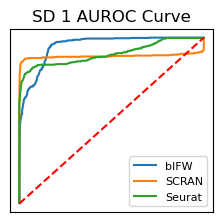

In [136]:
#plt.savefig(path + "Precison_Recall.png",dpi=800)
#plt.close()

bIFW_AUCROC = np.round(integrate(FPRs[0,:],Recalls[0,:]),3)
SCRAN_AUCROC = np.round(integrate(FPRs[1,:],Recalls[1,:]),3)
Seurat_AUCROC = np.round(integrate(FPRs[2,:],Recalls[2,:]),3)

## Plot the AUROC curves

plt.figure(figsize=(2.33,2.33))
plt.title("SD 1 AUROC Curve",fontsize=12)
plt.plot(FPRs[0,:],Recalls[0,:],label="bIFW")
plt.plot(FPRs[1,:],Recalls[1,:],label="SCRAN")
plt.plot(FPRs[2,:],Recalls[2,:],label="Seurat")
plt.plot(np.array([0,1]),c="red",linestyle="--")#,label="Random sampling")
#plt.xlabel("False positive rate",fontsize=14)
#plt.ylabel("True positive rate",fontsize=14)
plt.legend(prop={'size': 8})
plt.xticks([])
plt.yticks([])
plt.tight_layout()
#plt.savefig(path + "AUROC.png",dpi=800)
#plt.close()

plt.show()


run cESFW2 for comparison

In [11]:
# cESFW

''' Continuous Entropy Sort Feature Weighting (cESFW) '''

''' Here, Radley et al. provide the code for their cESFW software.
cESFW is a feature weighting algorithm designed for distinguishing between informative and uninformative features
in high dimensional data. cESFW is founded on the principles of Entropy Sorting, which Radley et al. have previously
described (1). 

cESFW was primarily designed with single cell RNA sequencing data in mind, but should be applicable to many different types of
high dimensional data, where the user would like to remove uninformative features. By focussing on significantly
correlating features in a dataset, it is hoped that downstream analysis of complex data should be improved.

(1) Entropy sorting of single-cell RNA sequencing (scRNA-seq) data reveals the inner cell mass in the human pre-implantation embryo. Arthur Radley, 
Elena Corujo-Simon, Jennifer Nichols, Austin Smith, Sara-Jane Dunn. Stem Cell Reports. 2023.'''

##### Dependencies #####

import numpy as np
import pandas as pd
from functools import partial 
import multiprocess
import scipy.sparse
from p_tqdm import p_map

path = 'c:/Users/sergi/Documents/GitHub/fw_mres/dev_syndata/'
trifdata = pd.read_csv(path +"/trif/trif_data.csv",header=0,index_col=0)

path = "C:/Users/sergi/Documents/GitHub/fw_mres/dev_syndata/cESFW/"

Scaled_Matrix = trifdata.copy()
print(f"Scaled_matrix object created.\n")
## Clip the top 2.5 percent of observed values for each gene to mitigate the effect of unusually high
# counts observations.

## Clip expression of each gene USING THE ZERO!!! nonzero does not work for some reason...
Upper = np.percentile(Scaled_Matrix,97.5,axis=0)
Upper[np.where(Upper == 0)[0]] = np.max(Scaled_Matrix,axis=0)[np.where(Upper == 0)[0]]
Scaled_Matrix = Scaled_Matrix.clip(upper=Upper,axis=1) 

## Normalise each feature/gene of the clipped matrix
Normalisation_Values = np.max(Scaled_Matrix,axis=0)
Scaled_Matrix = Scaled_Matrix / Normalisation_Values

## Remove confounding genes that are specifically expressed in one of the datasets (possible batch effect genes)
# Currently this step relies on EP > 0 with regard to a dummy feature representing an individual dataset.
# This potentially biases the downstream analysis to Entropy Sorting, and as such, we should try creating an equivilent
# function that utalises chi-squared significant that is used for the chi-squared workflow.

##
Feature_IDs = Scaled_Matrix.columns 
#Initial_Used_Features = Feature_IDs.copy()
#Dataset_IDs = np.unique(Human_Sample_Info["Dataset"])
## Track ESSs and EPs of each gene in relation to each dataset
#Dataset_ESSs = np.zeros((Initial_Used_Features.shape[0],Dataset_IDs.shape[0]))
#Dataset_EPs = np.zeros((Initial_Used_Features.shape[0],Dataset_IDs.shape[0]))
print(f'\nShape is: {Scaled_Matrix.shape}')
#necessary functions

def Calc_ESSs_EPs(Feature_Ind,Sample_Cardinality,Scaled_Matrix,Feature_Sums):
    import numpy as np
    global Global_Scaled_Matrix
    Global_Scaled_Matrix = np.asarray(Scaled_Matrix)
    ## Create the global Global_Scaled_Matrix_Inverse array for faster parallel computing calculations
    global Global_Scaled_Matrix_Inverse
    Global_Scaled_Matrix_Inverse = 1 - Global_Scaled_Matrix
    ## Extract the Fixed Feature (FF)
    Fixed_Feature = Global_Scaled_Matrix[:,Feature_Ind].reshape(Sample_Cardinality,1)
    Fixed_Feature_Cardinality = Feature_Sums[Feature_Ind]
    ##
    Minority_States = Feature_Sums.copy()
    Switch = np.where(Minority_States >= (Sample_Cardinality/2))[0]
    Minority_States[Switch] = Sample_Cardinality - Minority_States[Switch]
    ## Identify where FF is the QF or RF
    FF_QF_Vs_RF = np.zeros(Feature_Sums.shape[0])
    FF_QF_Vs_RF[np.where(Minority_States[Feature_Ind] > Minority_States)[0]] = 1 # 1's mean FF is QF
    ## Caclulate the QFms, RFms, RFMs and QFMs for each FF and secondary feature pair 
    RFms = Minority_States.copy()
    Switch = np.where(FF_QF_Vs_RF == 0)[0]
    RFms[Switch] = Minority_States[Feature_Ind]
    RFMs = Sample_Cardinality - RFms
    QFms = Minority_States.copy()
    Switch = np.where(FF_QF_Vs_RF == 1)[0]
    QFms[Switch] = Minority_States[Feature_Ind]
    QFMs = Sample_Cardinality - QFms
    ## Calculate the values of (x) that correspond to the maximum for each overlap scenario (mm, Mm, mM and MM) (m = minority, M = majority)
    Max_Ent_x_mm = (RFms * QFms)/(RFms + RFMs)
    Max_Ent_x_Mm = (QFMs * RFms)/(RFms + RFMs)
    Max_Ent_x_mM = (RFMs * QFms)/(RFms + RFMs)
    Max_Ent_x_MM = (RFMs * QFMs)/(RFms + RFMs)
    Max_Ent_Options = np.array([Max_Ent_x_mm,Max_Ent_x_Mm,Max_Ent_x_mM,Max_Ent_x_MM])
    ######
    ## Caclulate the overlap between the FF states and the secondary features, using the correct ESE (1-4)
    All_Use_Cases, All_Overlaps_Options = Get_Overlap_Info(Fixed_Feature,Fixed_Feature_Cardinality,Sample_Cardinality,Feature_Sums,FF_QF_Vs_RF)
    ## Having extracted the overlaps and their respective ESEs (1-4), calcualte the ESS and EPs
    ESSs, Divergent_EPs, Overhang_EPs, Max_CEs = Calc_ESSs(RFms, QFms, RFMs, QFMs, Max_Ent_Options, Sample_Cardinality, All_Overlaps_Options, All_Use_Cases) 
    return ESSs, Divergent_EPs, Overhang_EPs, Max_CEs


def Get_Overlap_Info(Fixed_Feature,Fixed_Feature_Cardinality,Sample_Cardinality,Feature_Sums,FF_QF_Vs_RF):
    ## Set up an array to track which of ESE equations 1-4 the recorded observed overlap relates to (row), and if it is 
    # native correlation (1) or flipped anti-correlation (-1). Row 1 = mm, row 2 = Mm, row 3 = mM, row 4 = MM.
    # FIRST LETTER IS QUERY, LAST IS REFERENCE!
    import numpy as np
    All_Use_Cases = np.zeros((4,Feature_Sums.shape[0]))
    ## Set up and away to track the observed overlaps between the FF and the secondary features.
    All_Overlaps_Options = np.zeros((4,Feature_Sums.shape[0]))
    ## Identify the non-zero inds in the FF, since samples with 0 can never observe overlap, and hence no need to do calculations.
    Non_Zero_Inds = np.where(Fixed_Feature != 0)[0]
    ## If FF is observed in it's minority state, use the following 4 steps to caclulate overlaps with every other feature
    if (Fixed_Feature_Cardinality < (Sample_Cardinality / 2)):
        #######
        ## FF and other feature are minority states & FF is QF
        Calc_Inds = np.where((Feature_Sums < (Sample_Cardinality / 2)) & (FF_QF_Vs_RF == 1))[0]
        ## Track which features are observed as mm (row 1), and which are mM when the secondary feature is flipped (row 3)
        ### if FF is QF, then FF is in the first position; for anticorrelation, we flip secondary feature, so second letter, row 3
        
        All_Use_Cases[:,Calc_Inds] = np.array([1,0,-1,0]).reshape(4,1)
        ## Calcualte the overlaps as the sum of minimums between samples, using Global_Scaled_Matrix for natural observations 
        # and Global_Scaled_Matrix_Inverse for inverse observations.
        All_Overlaps_Options[0,Calc_Inds] = np.sum(np.minimum(Fixed_Feature[Non_Zero_Inds],Global_Scaled_Matrix[np.ix_(Non_Zero_Inds,Calc_Inds)]),axis=0) # Overlaps_mm  
        All_Overlaps_Options[2,Calc_Inds] = np.sum(np.minimum(Fixed_Feature[Non_Zero_Inds],Global_Scaled_Matrix_Inverse[np.ix_(Non_Zero_Inds,Calc_Inds)]),axis=0) # Overlaps_mM
        ####### 
        ## FF and other feature are minority states & FF is RF
        Calc_Inds = np.where((Feature_Sums < (Sample_Cardinality / 2)) & (FF_QF_Vs_RF == 0))[0]
        ## Track which features are observed as mm (row 1), and which are Mm when the secondary feature is flipped (row 2)
        ### if FF is RF, then FF is in the second position; for anticorrelation, we flip secondary feature, so first letter, row 2
            ##### all other comparisons follow this logic

        All_Use_Cases[:,Calc_Inds] = np.array([1,-1,0,0]).reshape(4,1)
        ## Calcualte the overlaps as the sum of minimums between samples, using Global_Scaled_Matrix for natural observations 
        # and Global_Scaled_Matrix_Inverse for inverse observations.
        All_Overlaps_Options[0,Calc_Inds] = np.sum(np.minimum(Global_Scaled_Matrix[np.ix_(Non_Zero_Inds,Calc_Inds)],Fixed_Feature[Non_Zero_Inds]),axis=0) # Overlaps_mm
        All_Overlaps_Options[1,Calc_Inds] = np.sum(np.minimum(Global_Scaled_Matrix_Inverse[np.ix_(Non_Zero_Inds,Calc_Inds)],Fixed_Feature[Non_Zero_Inds]),axis=0) # Overlaps_Mm
        #######
        ## FF is minority, other feature is majority & FF is QF
        Calc_Inds = np.where((Feature_Sums >= (Sample_Cardinality / 2)) & (FF_QF_Vs_RF == 1))[0]
        ## Track which features are observed as mM (row 4), and which are mm when the secondary feature is flipped (row 1)
        All_Use_Cases[:,Calc_Inds] = np.array([-1,0,1,0]).reshape(4,1)
        ## Calcualte the overlaps as the sum of minimums between samples, using Global_Scaled_Matrix for natural observations 
        # and Global_Scaled_Matrix_Inverse for inverse observations.
        All_Overlaps_Options[0,Calc_Inds] = np.sum(np.minimum(Fixed_Feature[Non_Zero_Inds],Global_Scaled_Matrix_Inverse[np.ix_(Non_Zero_Inds,Calc_Inds)]),axis=0) # Overlaps_mm
        All_Overlaps_Options[2,Calc_Inds] = np.sum(np.minimum(Fixed_Feature[Non_Zero_Inds],Global_Scaled_Matrix[np.ix_(Non_Zero_Inds,Calc_Inds)]),axis=0) # Overlaps_mM
        #######
        ## FF is minority, other feature is majority & FF is RF
        Calc_Inds = np.where((Feature_Sums >= (Sample_Cardinality / 2)) & (FF_QF_Vs_RF == 0))[0]
        ## Track which features are observed as Mm (row 2), and which are mm when the secondary feature is flipped (row 1)
        All_Use_Cases[:,Calc_Inds] = np.array([-1,1,0,0]).reshape(4,1)
        ## Calcualte the overlaps as the sum of minimums between samples, using Global_Scaled_Matrix for natural observations 
        # and Global_Scaled_Matrix_Inverse for inverse observations.
        All_Overlaps_Options[0,Calc_Inds] = np.sum(np.minimum(Global_Scaled_Matrix_Inverse[np.ix_(Non_Zero_Inds,Calc_Inds)],Fixed_Feature[Non_Zero_Inds]),axis=0) # Overlaps_mm
        All_Overlaps_Options[1,Calc_Inds] = np.sum(np.minimum(Global_Scaled_Matrix[np.ix_(Non_Zero_Inds,Calc_Inds)],Fixed_Feature[Non_Zero_Inds]),axis=0) # Overlaps_Mm
        #
    ## If FF is observed in it's majority state, use the following 4 steps to caclulate overlaps with every other feature
    if (Fixed_Feature_Cardinality >= (Sample_Cardinality / 2)):
        #######
        ## FF is majority, other feature is minority & FF is QF 
        Calc_Inds = np.where((Feature_Sums < (Sample_Cardinality / 2)) & (FF_QF_Vs_RF == 1))[0]
        ## Track which features are observed as Mm (row 2), and which are MM when the secondary feature is flipped (row 4)
        All_Use_Cases[:,Calc_Inds] = np.array([0,1,0,-1]).reshape(4,1)
        ## Calcualte the overlaps as the sum of minimums between samples, using Global_Scaled_Matrix for natural observations 
        # and Global_Scaled_Matrix_Inverse for inverse observations.        
        All_Overlaps_Options[1,Calc_Inds] = np.sum(np.minimum(Fixed_Feature[Non_Zero_Inds],Global_Scaled_Matrix[np.ix_(Non_Zero_Inds,Calc_Inds)]),axis=0) # Overlaps_Mm
        All_Overlaps_Options[3,Calc_Inds] = np.sum(np.minimum(Fixed_Feature[Non_Zero_Inds],Global_Scaled_Matrix_Inverse[np.ix_(Non_Zero_Inds,Calc_Inds)]),axis=0) # Overlaps_MM
        #######
        ## FF is majority, other feature is minority & FF is RF
        Calc_Inds = np.where((Feature_Sums < (Sample_Cardinality / 2)) & (FF_QF_Vs_RF == 0))[0]
        ## Track which features are observed as mM (row 3), and which are MM when the secondary feature is flipped (row 4)
        All_Use_Cases[:,Calc_Inds] = np.array([0,0,1,-1]).reshape(4,1)
        ## Calcualte the overlaps as the sum of minimums between samples, using Global_Scaled_Matrix for natural observations 
        # and Global_Scaled_Matrix_Inverse for inverse observations.     
        All_Overlaps_Options[2,Calc_Inds] = np.sum(np.minimum(Global_Scaled_Matrix[np.ix_(Non_Zero_Inds,Calc_Inds)],Fixed_Feature[Non_Zero_Inds]),axis=0) # Overlaps_mM
        All_Overlaps_Options[3,Calc_Inds] = np.sum(np.minimum(Global_Scaled_Matrix_Inverse[np.ix_(Non_Zero_Inds,Calc_Inds)],Fixed_Feature[Non_Zero_Inds]),axis=0) # Overlaps_MM   
        #######
        ## FF is majority, other feature is majority & FF is QF
        Calc_Inds = np.where((Feature_Sums >= (Sample_Cardinality / 2)) & (FF_QF_Vs_RF == 1))[0]
        ## Track which features are observed as MM (row 4), and which are Mm when the secondary feature is flipped (row 2)
        All_Use_Cases[:,Calc_Inds] = np.array([0,-1,0,1]).reshape(4,1)
        ## Calcualte the overlaps as the sum of minimums between samples, using Global_Scaled_Matrix for natural observations 
        # and Global_Scaled_Matrix_Inverse for inverse observations. 
        All_Overlaps_Options[1,Calc_Inds] = np.sum(np.minimum(Fixed_Feature[Non_Zero_Inds],Global_Scaled_Matrix_Inverse[np.ix_(Non_Zero_Inds,Calc_Inds)]),axis=0) # Overlaps_Mm
        All_Overlaps_Options[3,Calc_Inds] = np.sum(np.minimum(Fixed_Feature[Non_Zero_Inds],Global_Scaled_Matrix[np.ix_(Non_Zero_Inds,Calc_Inds)]),axis=0) # Overlaps_MM
        #######
        ## FF is majority, other feature is majority & FF is RF
        Calc_Inds = np.where((Feature_Sums >= (Sample_Cardinality / 2)) & (FF_QF_Vs_RF == 0))[0]
        ## Track which features are observed as MM (row 4), and which are mM when the secondary feature is flipped (row 3)
        All_Use_Cases[:,Calc_Inds] = np.array([0,0,-1,1]).reshape(4,1)
        ## Calcualte the overlaps as the sum of minimums between samples, using Global_Scaled_Matrix for natural observations 
        # and Global_Scaled_Matrix_Inverse for inverse observations. 
        All_Overlaps_Options[2,Calc_Inds] = np.sum(np.minimum(Global_Scaled_Matrix_Inverse[np.ix_(Non_Zero_Inds,Calc_Inds)],Fixed_Feature[Non_Zero_Inds]),axis=0) # Overlaps_mM
        All_Overlaps_Options[3,Calc_Inds] = np.sum(np.minimum(Global_Scaled_Matrix[np.ix_(Non_Zero_Inds,Calc_Inds)],Fixed_Feature[Non_Zero_Inds]),axis=0)
        #
    return All_Use_Cases, All_Overlaps_Options


def Calc_ESSs(RFms, QFms, RFMs, QFMs, Max_Ent_Options, Sample_Cardinality, All_Overlaps_Options, All_Use_Cases):
    ## Create variables to track caclulation outputs
    # Track the Observed, Local Minimum, Global Minimum and Maximum entropoes of the observed feature pairs
    Native_CEs = np.zeros((4,RFms.shape[0]))
    # Track the Observed, Local Minimum, Global Minimum and Maximum entropoes of the flipped secondary feature feature pairs
    Flipped_CEs = np.zeros((4,RFms.shape[0]))
    # Track all SDs, SWs and SGs
    All_SDs = np.zeros((4,RFms.shape[0]))
    All_SWs = np.zeros((4,RFms.shape[0]))
    All_SGs = np.zeros((4,RFms.shape[0]))
    All_Correlations = np.zeros((4,RFms.shape[0]))
    # Track the minumm and maximum boundary point overlap values for the relevent ESEs
    All_Min_xs = np.zeros((4,RFms.shape[0]))
    All_Max_xs = np.zeros((4,RFms.shape[0]))
    ###################
    ##### (1)  mm #####
    Use_Curve = 0
    ## Find the FF/SF pairs where we should use ESE (1) to calculate entropies
    Calc_Inds = np.where(All_Use_Cases[Use_Curve,:] != 0)[0]
    if Calc_Inds.shape[0] > 0:
        # Retrieve the Max_Ent, Min_x, Max_X and observed overlap values
        Max_Ent_x = Max_Ent_Options[Use_Curve,Calc_Inds]
        Min_x = np.repeat(0,Calc_Inds.shape[0])
        Max_x = np.minimum(RFms[Calc_Inds],QFms[Calc_Inds])
        Overlaps = All_Overlaps_Options[Use_Curve,Calc_Inds]
        # Track the Min and Max values for downstream EP calculations
        All_Min_xs[Use_Curve,Calc_Inds] = Min_x
        All_Max_xs[Use_Curve,Calc_Inds] = Max_x
        # Perform caclulations with ESE (1)
        Xs = np.stack((Overlaps,Min_x,Max_x,Max_Ent_x))
        G1 = (RFms[Calc_Inds]/Sample_Cardinality)*((-((Xs/RFms[Calc_Inds])*np.log2(Xs/RFms[Calc_Inds]))-(((RFms[Calc_Inds]-Xs)/RFms[Calc_Inds])*np.log2((RFms[Calc_Inds]-Xs)/RFms[Calc_Inds]))))
        G1[np.isnan(G1)] = 0
        G2 = (RFMs[Calc_Inds]/Sample_Cardinality)*((-(((QFms[Calc_Inds]-Xs)/RFMs[Calc_Inds])*np.log2((QFms[Calc_Inds]-Xs)/RFMs[Calc_Inds]))-(((RFMs[Calc_Inds]-QFms[Calc_Inds]+Xs)/RFMs[Calc_Inds])*np.log2((RFMs[Calc_Inds]-QFms[Calc_Inds]+Xs)/RFMs[Calc_Inds]))))
        G2[np.isnan(G2)] = 0
        CEs = G1 + G2
        # Save the CEs for the native FF/SF pairings
        Native_Inds = np.where(All_Use_Cases[Use_Curve,Calc_Inds] == 1)[0]
        Native_CEs[:,Calc_Inds[Native_Inds]] = CEs[:,Native_Inds]
        # Save the CEs for the native FF/SF pairings
        Flipped_Inds = np.where(All_Use_Cases[Use_Curve,Calc_Inds] == -1)[0]
        Flipped_CEs[:,Calc_Inds[Flipped_Inds]] = CEs[:,Flipped_Inds]
        # Caclulate ESSs
        SD = np.zeros(Calc_Inds.shape[0])
        Correlation = np.zeros(Calc_Inds.shape[0])
        #
        ESS_Inds = np.where(Overlaps < Max_Ent_x)[0]
        SD[ESS_Inds] = -1
        Correlation[ESS_Inds] = -1
        All_SWs[Use_Curve,Calc_Inds[ESS_Inds]] = (CEs[3,ESS_Inds] - CEs[1,ESS_Inds]) / CEs[3,ESS_Inds]
        All_SGs[Use_Curve,Calc_Inds[ESS_Inds]] = (CEs[3,ESS_Inds] - CEs[0,ESS_Inds]) / (CEs[3,ESS_Inds] - CEs[1,ESS_Inds])
        #
        ESS_Inds = np.where(Overlaps >= Max_Ent_x)[0]
        SD[ESS_Inds] = 1
        Correlation[ESS_Inds] = 1
        All_SWs[Use_Curve,Calc_Inds[ESS_Inds]] = (CEs[3,ESS_Inds] - CEs[2,ESS_Inds]) / CEs[3,ESS_Inds]
        All_SGs[Use_Curve,Calc_Inds[ESS_Inds]] = (CEs[3,ESS_Inds] - CEs[0,ESS_Inds]) / (CEs[3,ESS_Inds] - CEs[2,ESS_Inds])     
        # 
        # Flip_SDs = np.where(CEs[1,:] < CEs[2,:])[0]
        # SD[Flip_SDs] = SD[Flip_SDs] * -1
        All_SDs[Use_Curve,Calc_Inds] = SD
        All_Correlations[Use_Curve,Calc_Inds] = Correlation
    ###################
    ##### (2)  Mm #####
    Use_Curve = 1
    ## Find the FF/SF pairs where we should use ESE (2) to calculate entropies
    Calc_Inds = np.where(All_Use_Cases[Use_Curve,:] != 0)[0]
    if Calc_Inds.shape[0] > 0:
        # Retrieve the Max_Ent, Min_x, Max_X and observed overlap values
        Max_Ent_x = Max_Ent_Options[Use_Curve,Calc_Inds]
        Min_x = np.maximum(0, QFMs[Calc_Inds]-RFMs[Calc_Inds]) # QFMs[Calc_Inds]-RFMs[Calc_Inds]??
        Max_x = np.minimum(RFms[Calc_Inds],QFMs[Calc_Inds])
        Overlaps =  All_Overlaps_Options[Use_Curve,Calc_Inds]
        # Track the Min and Max values for downstream EP calculations
        All_Min_xs[Use_Curve,Calc_Inds] = Min_x
        All_Max_xs[Use_Curve,Calc_Inds] = Max_x
        # Perform caclulations with ESE (2)
        Xs = np.stack((Overlaps,Min_x,Max_x,Max_Ent_x))
        G1 = (RFms[Calc_Inds]/Sample_Cardinality)*((-(((RFms[Calc_Inds]-Xs)/RFms[Calc_Inds])*np.log2((RFms[Calc_Inds]-Xs)/RFms[Calc_Inds]))-(((Xs)/RFms[Calc_Inds])*np.log2((Xs)/RFms[Calc_Inds]))))
        G1[np.isnan(G1)] = 0
        G2 = (RFMs[Calc_Inds]/Sample_Cardinality)*((-(((RFMs[Calc_Inds]-QFMs[Calc_Inds]+Xs)/RFMs[Calc_Inds])*np.log2((RFMs[Calc_Inds]-QFMs[Calc_Inds]+Xs)/RFMs[Calc_Inds]))-(((QFMs[Calc_Inds]-Xs)/RFMs[Calc_Inds])*np.log2((QFMs[Calc_Inds]-Xs)/RFMs[Calc_Inds]))))
        G2[np.isnan(G2)] = 0
        CEs = G1 + G2
        # Save the CEs for the native FF/SF pairings
        Native_Inds = np.where(All_Use_Cases[Use_Curve,Calc_Inds] == 1)[0]
        Native_CEs[:,Calc_Inds[Native_Inds]] = CEs[:,Native_Inds]
        # Save the CEs for the native FF/SF pairings
        Flipped_Inds = np.where(All_Use_Cases[Use_Curve,Calc_Inds] == -1)[0]
        Flipped_CEs[:,Calc_Inds[Flipped_Inds]] = CEs[:,Flipped_Inds]
        # Caclulate ESSs
        SD = np.zeros(Calc_Inds.shape[0])
        Correlation = np.zeros(Calc_Inds.shape[0])
        #
        ESS_Inds = np.where(Overlaps < Max_Ent_x)[0]
        SD[ESS_Inds] = -1
        Correlation[ESS_Inds] = 1
        All_SWs[Use_Curve,Calc_Inds[ESS_Inds]] = (CEs[3,ESS_Inds] - CEs[1,ESS_Inds]) / CEs[3,ESS_Inds]
        All_SGs[Use_Curve,Calc_Inds[ESS_Inds]] = (CEs[3,ESS_Inds] - CEs[0,ESS_Inds]) / (CEs[3,ESS_Inds] - CEs[1,ESS_Inds])
        #
        ESS_Inds = np.where(Overlaps >= Max_Ent_x)[0]
        SD[ESS_Inds] = 1
        Correlation[ESS_Inds] = -1
        All_SWs[Use_Curve,Calc_Inds[ESS_Inds]] = (CEs[3,ESS_Inds] - CEs[2,ESS_Inds]) / CEs[3,ESS_Inds]
        All_SGs[Use_Curve,Calc_Inds[ESS_Inds]] = (CEs[3,ESS_Inds] - CEs[0,ESS_Inds]) / (CEs[3,ESS_Inds] - CEs[2,ESS_Inds])
        #  
        # Flip_SDs = np.where(CEs[1,:] < CEs[2,:])[0]
        # SD[Flip_SDs] = SD[Flip_SDs] * -1 
        All_SDs[Use_Curve,Calc_Inds] = SD
        All_Correlations[Use_Curve,Calc_Inds] = Correlation
    ###################
    ##### (3)  mM #####
    Use_Curve = 2
    ## Find the FF/SF pairs where we should use ESE (3) to calculate entropies
    Calc_Inds = np.where(All_Use_Cases[Use_Curve,:] != 0)[0]
    if Calc_Inds.shape[0] > 0:
        # Retrieve the Max_Ent, Min_x, Max_X and observed overlap values
        Max_Ent_x = Max_Ent_Options[Use_Curve,Calc_Inds]
        Min_x = np.maximum(0, RFMs[Calc_Inds]-QFMs[Calc_Inds])
        Max_x = np.minimum(QFms[Calc_Inds],RFMs[Calc_Inds])
        Overlaps =  All_Overlaps_Options[Use_Curve,Calc_Inds]
        # Track the Min and Max values for downstream EP calculations
        All_Min_xs[Use_Curve,Calc_Inds] = Min_x
        All_Max_xs[Use_Curve,Calc_Inds] = Max_x
        # Perform caclulations with ESE (3)
        Xs = np.stack((Overlaps,Min_x,Max_x,Max_Ent_x))
        G1 = (RFms[Calc_Inds]/Sample_Cardinality)*((-(((QFms[Calc_Inds]-Xs)/RFms[Calc_Inds])*np.log2((QFms[Calc_Inds]-Xs)/RFms[Calc_Inds]))-(((RFms[Calc_Inds]-QFms[Calc_Inds]+Xs)/RFms[Calc_Inds])*np.log2((RFms[Calc_Inds]-QFms[Calc_Inds]+Xs)/RFms[Calc_Inds]))))
        G1[np.isnan(G1)] = 0
        G2 = (RFMs[Calc_Inds]/Sample_Cardinality)*((-(((Xs)/RFMs[Calc_Inds])*np.log2((Xs)/RFMs[Calc_Inds]))-(((RFMs[Calc_Inds]-Xs)/RFMs[Calc_Inds])*np.log2((RFMs[Calc_Inds]-Xs)/RFMs[Calc_Inds]))))
        G2[np.isnan(G2)] = 0
        CEs = G1 + G2
        # Save the CEs for the native FF/SF pairings
        Native_Inds = np.where(All_Use_Cases[Use_Curve,Calc_Inds] == 1)[0]
        Native_CEs[:,Calc_Inds[Native_Inds]] = CEs[:,Native_Inds]
        # Save the CEs for the native FF/SF pairings
        Flipped_Inds = np.where(All_Use_Cases[Use_Curve,Calc_Inds] == -1)[0]
        Flipped_CEs[:,Calc_Inds[Flipped_Inds]] = CEs[:,Flipped_Inds]
        # Caclulate ESSs
        SD = np.zeros(Calc_Inds.shape[0])
        Correlation = np.zeros(Calc_Inds.shape[0])
        #
        ESS_Inds = np.where(Overlaps < Max_Ent_x)[0]
        SD[ESS_Inds] = -1
        Correlation[ESS_Inds] = 1
        All_SWs[Use_Curve,Calc_Inds[ESS_Inds]] = (CEs[3,ESS_Inds] - CEs[1,ESS_Inds]) / CEs[3,ESS_Inds]
        All_SGs[Use_Curve,Calc_Inds[ESS_Inds]] = (CEs[3,ESS_Inds] - CEs[0,ESS_Inds]) / (CEs[3,ESS_Inds] - CEs[1,ESS_Inds])
        #
        ESS_Inds = np.where(Overlaps >= Max_Ent_x)[0]
        SD[ESS_Inds] = 1
        Correlation[ESS_Inds] = -1
        All_SWs[Use_Curve,Calc_Inds[ESS_Inds]] = (CEs[3,ESS_Inds] - CEs[2,ESS_Inds]) / CEs[3,ESS_Inds]
        All_SGs[Use_Curve,Calc_Inds[ESS_Inds]] = (CEs[3,ESS_Inds] - CEs[0,ESS_Inds]) / (CEs[3,ESS_Inds] - CEs[2,ESS_Inds]) 
        #
        # Flip_SDs = np.where(CEs[1,:] < CEs[2,:])[0]
        # SD[Flip_SDs] = SD[Flip_SDs] * -1
        All_SDs[Use_Curve,Calc_Inds] = SD
        All_Correlations[Use_Curve,Calc_Inds] = Correlation
    ###################
    ##### (4)  MM #####
    Use_Curve = 3
    ## Find the FF/SF pairs where we should use ESE (4) to calculate entropies
    Calc_Inds = np.where(All_Use_Cases[Use_Curve,:] != 0)[0]
    if Calc_Inds.shape[0] > 0:
        # Retrieve the Max_Ent, Min_x, Max_X and observed overlap values
        Max_Ent_x = Max_Ent_Options[Use_Curve,Calc_Inds]
        Min_x = QFMs-RFms
        Max_x = np.minimum(QFMs[Calc_Inds],RFMs[Calc_Inds])
        Overlaps =  All_Overlaps_Options[Use_Curve,Calc_Inds]
        # Track the Min and Max values for downstream EP calculations
        All_Min_xs[Use_Curve,Calc_Inds] = Min_x
        All_Max_xs[Use_Curve,Calc_Inds] = Max_x
        # Perform caclulations with ESE (4)
        Xs = np.stack((Overlaps,Min_x,Max_x,Max_Ent_x))
        G1 = (RFms[Calc_Inds]/Sample_Cardinality)*((-(((RFms[Calc_Inds]-QFMs[Calc_Inds]+Xs)/RFms[Calc_Inds])*np.log2((RFms[Calc_Inds]-QFMs[Calc_Inds]+Xs)/RFms[Calc_Inds]))-(((QFMs[Calc_Inds]-Xs)/RFms[Calc_Inds])*np.log2((QFMs[Calc_Inds]-Xs)/RFms[Calc_Inds]))))
        G1[np.isnan(G1)] = 0
        G2 = (RFMs[Calc_Inds]/Sample_Cardinality)*((-(((RFMs[Calc_Inds]-Xs)/RFMs[Calc_Inds])*np.log2((RFMs[Calc_Inds]-Xs)/RFMs[Calc_Inds]))-(((Xs)/RFMs[Calc_Inds])*np.log2((Xs)/RFMs))))
        G2[np.isnan(G2)] = 0
        CEs = G1 + G2
        # Save the CEs for the native FF/SF pairings
        Native_Inds = np.where(All_Use_Cases[Use_Curve,Calc_Inds] == 1)[0]
        Native_CEs[:,Calc_Inds[Native_Inds]] = CEs[:,Native_Inds]
        # Save the CEs for the native FF/SF pairings
        Flipped_Inds = np.where(All_Use_Cases[Use_Curve,Calc_Inds] == -1)[0]
        Flipped_CEs[:,Calc_Inds[Flipped_Inds]] = CEs[:,Flipped_Inds]
        # Caclulate ESSs
        SD = np.zeros(Calc_Inds.shape[0])
        Correlation = np.zeros(Calc_Inds.shape[0])
        #
        ESS_Inds = np.where(Overlaps < Max_Ent_x)[0]
        SD[ESS_Inds] = -1
        Correlation[ESS_Inds] = -1
        All_SWs[Use_Curve,Calc_Inds[ESS_Inds]] = (CEs[3,ESS_Inds] - CEs[1,ESS_Inds]) / CEs[3,ESS_Inds]
        All_SGs[Use_Curve,Calc_Inds[ESS_Inds]] = (CEs[3,ESS_Inds] - CEs[0,ESS_Inds]) / (CEs[3,ESS_Inds] - CEs[1,ESS_Inds])
        #
        ESS_Inds = np.where(Overlaps >= Max_Ent_x)[0]
        SD[ESS_Inds] = 1
        Correlation[ESS_Inds] = 1
        All_SWs[Use_Curve,Calc_Inds[ESS_Inds]] = (CEs[3,ESS_Inds] - CEs[2,ESS_Inds]) / CEs[3,ESS_Inds]
        All_SGs[Use_Curve,Calc_Inds[ESS_Inds]] = (CEs[3,ESS_Inds] - CEs[0,ESS_Inds]) / (CEs[3,ESS_Inds] - CEs[2,ESS_Inds])   
        #
        # Flip_SDs = np.where(CEs[1,:] < CEs[2,:])[0]
        # SD[Flip_SDs] = SD[Flip_SDs] * -1
        All_SDs[Use_Curve,Calc_Inds] = SD
        All_Correlations[Use_Curve,Calc_Inds] = Correlation
    ## Multiply components to get ESS
    All_ESSs = All_SGs * All_SWs * All_Correlations
    ###################
    #### Calc EPs ####
    Divergent_EPs = np.zeros(RFms.shape[0])
    Overhang_EPs = np.zeros(RFms.shape[0])
    #
    Max_ESS_Inds = np.argmax(np.absolute(All_ESSs),axis=0)
    ESS_0_Inds = np.where(np.max(All_ESSs,axis=0) == 0)[0]
    Max_ESS_Inds[ESS_0_Inds] = np.argmax(All_SDs[:,ESS_0_Inds],axis=0)
    Max_ESS_Use_Cases = All_Use_Cases[Max_ESS_Inds,np.arange(RFms.shape[0])]
    Max_ESS_Max_Ents = Max_Ent_Options[Max_ESS_Inds,np.arange(RFms.shape[0])]
    Max_ESS_Overlaps = All_Overlaps_Options[Max_ESS_Inds,np.arange(RFms.shape[0])]
    Max_ESS_Min_xs = All_Min_xs[Max_ESS_Inds,np.arange(RFms.shape[0])]
    Max_ESS_Max_xs = All_Max_xs[Max_ESS_Inds,np.arange(RFms.shape[0])]
    Max_ESS_SDs = All_SDs[Max_ESS_Inds,np.arange(RFms.shape[0])]
    #
    CEs = np.zeros(Native_CEs.shape)
    Use_Case_Inds_1 = np.where(Max_ESS_Use_Cases==1)[0]
    CEs[:,Use_Case_Inds_1] = Native_CEs[:,Use_Case_Inds_1]
    Use_Case_Inds_2 = np.where(Max_ESS_Use_Cases==-1)[0]
    CEs[:,Use_Case_Inds_2] = Flipped_CEs[:,Use_Case_Inds_2]
    #
    Num_Divegent_Cells = np.zeros(Max_ESS_Inds.shape[0])
    Num_Overhang_Cells = np.zeros(Max_ESS_Inds.shape[0])
    ## mm (1), SD = -1
    Inds = np.where((Max_ESS_Inds == 0) & (Max_ESS_SDs == -1))[0]
    Num_Divegent_Cells[Inds] = Max_ESS_Overlaps[Inds]
    Num_Overhang_Cells[Inds] = Sample_Cardinality - (QFms[Inds] + RFms[Inds]) + Max_ESS_Overlaps[Inds]
    ## mm (1), SD = 1
    Inds = np.where((Max_ESS_Inds == 0) & (Max_ESS_SDs == 1))[0]
    Num_Divegent_Cells[Inds] = RFms[Inds] - Max_ESS_Overlaps[Inds]
    Num_Overhang_Cells[Inds] = QFms[Inds] - Max_ESS_Overlaps[Inds] 
    ## Mm (2), SD = -1
    Inds = np.where((Max_ESS_Inds == 1) & (Max_ESS_SDs == -1))[0]
    Num_Divegent_Cells[Inds] = Max_ESS_Overlaps[Inds]
    Num_Overhang_Cells[Inds] = QFms[Inds] - RFms[Inds] + Max_ESS_Overlaps[Inds]
    ## Mm (2), SD = 1
    Inds = np.where((Max_ESS_Inds == 1) & (Max_ESS_SDs == 1))[0]
    Num_Divegent_Cells[Inds] = (RFms[Inds] - Max_ESS_Overlaps[Inds]) # Changed
    Num_Overhang_Cells[Inds] = (QFMs[Inds] - RFms[Inds] + Num_Divegent_Cells[Inds]) # Changed
    ## mM (3), SD = -1
    Inds = np.where((Max_ESS_Inds == 2) & (Max_ESS_SDs == -1))[0]
    Num_Overhang_Cells[Inds] = Max_ESS_Overlaps[Inds]
    Num_Divegent_Cells[Inds] = (QFMs[Inds] - RFMs[Inds]) + Num_Overhang_Cells[Inds] # Changed
    ## mM (3), SD = 1
    Inds = np.where((Max_ESS_Inds == 2) & (Max_ESS_SDs == 1))[0]
    Num_Divegent_Cells[Inds] = QFms[Inds] - Max_ESS_Overlaps[Inds]
    Num_Overhang_Cells[Inds] = RFMs[Inds] - Max_ESS_Overlaps[Inds] # Changed Sample_Cardinality - (QFms[Inds] + RFms[Inds]) + Max_ESS_Overlaps[Inds]
    ## MM, SD = -1
    Inds = np.where((Max_ESS_Inds == 3) & (Max_ESS_SDs == -1))[0]
    Num_Divegent_Cells[Inds] = Max_ESS_Overlaps[Inds] - (Sample_Cardinality - (QFms[Inds] + RFms[Inds]))
    Num_Overhang_Cells[Inds] = Max_ESS_Overlaps[Inds] # Changed (Sample_Cardinality - (QFms[Inds] + RFms[Inds])) + Num_Divegent_Cells[Inds]
    ## MM, SD = 1
    Inds = np.where((Max_ESS_Inds == 3) & (Max_ESS_SDs == 1))[0]
    Num_Divegent_Cells[Inds] = QFMs[Inds] - Max_ESS_Overlaps[Inds] # Changed
    Num_Overhang_Cells[Inds] = RFMs[Inds] - QFMs[Inds] + Num_Divegent_Cells[Inds] # Changed
    #
    Num_Divegent_Cells[Num_Divegent_Cells < 0.0000001] = 0
    Num_Overhang_Cells[Num_Overhang_Cells < 0.0000001] = 0
    #
    EP_Inds = np.where(Max_ESS_SDs == -1)[0]
    DPCd = (CEs[0,EP_Inds] - CEs[1,EP_Inds]) / Num_Divegent_Cells[EP_Inds]
    DPCo = CEs[0,EP_Inds] / Num_Overhang_Cells[EP_Inds] # DPC overhang
    DPCi = CEs[3,EP_Inds] / (Max_ESS_Max_Ents[EP_Inds] - Max_ESS_Min_xs[EP_Inds])
    Divergent_EPs[EP_Inds] = DPCd - DPCi
    Overhang_EPs[EP_Inds] = DPCo - DPCi
    # EPs: SDs = 1
    EP_Inds = np.where(Max_ESS_SDs == 1)[0]
    # Divergent_Cells = Max_ESS_Max_xs[EP_Inds] - Max_ESS_Overlaps[EP_Inds]
    # Divergent_Cells[Divergent_Cells < 0.0000001] = 0
    DPCd = (CEs[0,EP_Inds] - CEs[2,EP_Inds]) / Num_Divegent_Cells[EP_Inds]
    DPCo = CEs[0,EP_Inds] / Num_Overhang_Cells[EP_Inds] # DPC overhang
    DPCi = CEs[3,EP_Inds] / (Max_ESS_Max_xs[EP_Inds] - Max_ESS_Max_Ents[EP_Inds])
    Divergent_EPs[EP_Inds] = DPCd - DPCi
    Overhang_EPs[EP_Inds] = DPCo - DPCi
    return All_ESSs[Max_ESS_Inds,np.arange(RFms.shape[0])], Divergent_EPs, Overhang_EPs, CEs[3,:]

########

def Calc_Individual_ESSs_EPs(Fixed_Feature, Scaled_Matrix):
    Sample_Cardinality = Fixed_Feature.shape[0]
    Fixed_Feature = Fixed_Feature.reshape(Sample_Cardinality,1)
    #
    ## Save feature ID names for later
    Feature_IDs = Scaled_Matrix.columns
    ## Create the global Global_Scaled_Matrix array for faster parallel computing calculations
    global Global_Scaled_Matrix
    Global_Scaled_Matrix = np.asarray(Scaled_Matrix)
    ## Create the global Global_Scaled_Matrix_Inverse array for faster parallel computing calculations
    global Global_Scaled_Matrix_Inverse
    Global_Scaled_Matrix_Inverse = 1 - Global_Scaled_Matrix
    ## Extract sample cardinality
    Sample_Cardinality = Global_Scaled_Matrix.shape[0]
    ## Calculate feature sums
    Feature_Sums = np.asarray(np.sum(Global_Scaled_Matrix,axis=0))
    #
    Fixed_Feature_Cardinality = np.sum(Fixed_Feature)
    Feature_Sums = np.asarray(np.sum(Global_Scaled_Matrix,axis=0))
    #
    FF_QF_Vs_RF = np.zeros(Feature_Sums.shape[0])
    FF_QF_Vs_RF[np.where(Fixed_Feature_Cardinality > Feature_Sums)[0]] = 1 # 1's mean FF is QF
    #
    RFms = Feature_Sums.copy()
    Switch = np.where(FF_QF_Vs_RF == 0)[0]
    RFms[Switch] = Fixed_Feature_Cardinality
    RFMs = Sample_Cardinality - RFms
    QFms = Feature_Sums.copy()
    Switch = np.where(FF_QF_Vs_RF == 1)[0]
    QFms[Switch] = Fixed_Feature_Cardinality
    QFMs = Sample_Cardinality - QFms
    #
    Max_Ent_x_mm = (RFms * QFms)/(RFms + RFMs)
    Max_Ent_x_Mm = (QFMs * RFms)/(RFms + RFMs)
    Max_Ent_x_mM = (RFMs * QFms)/(RFms + RFMs)
    Max_Ent_x_MM = (RFMs * QFMs)/(RFms + RFMs)
    Max_Ent_Options = np.array([Max_Ent_x_mm,Max_Ent_x_Mm,Max_Ent_x_mM,Max_Ent_x_MM])
    ###################
    All_Use_Cases, All_Overlaps_Options = Get_Overlap_Info(Fixed_Feature,Fixed_Feature_Cardinality,Sample_Cardinality,Feature_Sums,FF_QF_Vs_RF)
    ESSs, Divergent_EPs, Overhang_EPs, Max_CEs = Calc_ESSs(RFms, QFms, RFMs, QFMs, Max_Ent_Options, Sample_Cardinality, All_Overlaps_Options, All_Use_Cases) 
    Divergent_EPs[np.isnan(Divergent_EPs)] = 0
    Divergent_EPs[np.isinf(Divergent_EPs)] = 0
    Overhang_EPs[np.isnan(Overhang_EPs)] = 0
    Overhang_EPs[np.isinf(Overhang_EPs)] = 0
    return pd.DataFrame(ESSs.reshape(1,Feature_IDs.shape[0]), columns=Feature_IDs), pd.DataFrame(Divergent_EPs.reshape(1,Feature_IDs.shape[0]), columns=Feature_IDs), pd.DataFrame(Overhang_EPs.reshape(1,Feature_IDs.shape[0]), columns=Feature_IDs)

### now we conduct the analysis

def Parallel_Calc_ESSs_EPs(Scaled_Matrix,Use_Cores=30):
    ## Save feature ID names for later
    import numpy as np
    Feature_IDs = Scaled_Matrix.columns
    ## Create the global Global_Scaled_Matrix array for faster parallel computing calculations
    global Global_Scaled_Matrix
    Global_Scaled_Matrix = np.asarray(Scaled_Matrix)
    ## Create the global Global_Scaled_Matrix_Inverse array for faster parallel computing calculations
    global Global_Scaled_Matrix_Inverse
    Global_Scaled_Matrix_Inverse = 1 - Global_Scaled_Matrix
    ## Extract sample and feature cardinality
    Sample_Cardinality = Global_Scaled_Matrix.shape[0]
    Feature_Cardinality = Global_Scaled_Matrix.shape[1]
    ## Calculate feature sums
    Feature_Sums = np.asarray(np.sum(Global_Scaled_Matrix,axis=0))
    ## Provide indicies for parallel computing.
    Feature_Inds = np.arange(Feature_Cardinality)
    ## Identify number of cores to use.
    Cores_Available = multiprocess.cpu_count()
    print("Cores Available: " + str(Cores_Available))
    if Use_Cores == -1:
        Use_Cores = Cores_Available - 1 # -1 Is an arbitrary buffer of idle cores that I set.
        if Use_Cores < 1:
            Use_Cores = 1
    print("Cores Used: " + str(Use_Cores))
    ## Perform calculations
    if __name__ == '__main__':
        import numpy as np
        with np.errstate(divide='ignore',invalid='ignore'):
            Results = p_map(partial(Calc_ESSs_EPs,Sample_Cardinality=Sample_Cardinality,Feature_Sums=Feature_Sums, Scaled_Matrix = Scaled_Matrix), Feature_Inds, num_cpus=Use_Cores)
    ## Extract results: [ESS, DivEP, OverhangEP, maxCE]
    Results = np.asarray(Results)
    ESSs = Results[:,0]
    Divergent_EPs = Results[:,1]
    Divergent_EPs[np.isnan(Divergent_EPs)] = 0
    Divergent_EPs[np.isinf(Divergent_EPs)] = 0
    Overhang_EPs = Results[:,2]
    Overhang_EPs[np.isnan(Overhang_EPs)] = 0
    Overhang_EPs[np.isinf(Overhang_EPs)] = 0
    Max_CEs = Results[:,3]
    #
    # ESSs[ESSs < 0.0000001] = 0
    ESS_0_Inds = np.where(ESSs == 0)
    Inverse_ESS_0_Inds = (ESS_0_Inds[1],ESS_0_Inds[0])
    # why is this here???
    Values = Divergent_EPs[ESS_0_Inds]
    Inverse_Values = Divergent_EPs[Inverse_ESS_0_Inds]
    Substitute_Inds = np.where(Values < Inverse_Values)[0]
    Values[Substitute_Inds] = Inverse_Values[Substitute_Inds]
    Divergent_EPs[ESS_0_Inds] = Values
    # Same for overhangs
    Values = Overhang_EPs[ESS_0_Inds]
    Inverse_Values = Overhang_EPs[Inverse_ESS_0_Inds]
    Substitute_Inds = np.where(Values < Inverse_Values)[0]
    Values[Substitute_Inds] = Inverse_Values[Substitute_Inds]
    Overhang_EPs[ESS_0_Inds] = Values
    #
    return ESSs, Divergent_EPs, Overhang_EPs, Max_CEs

global Global_Scaled_Matrix
Global_Scaled_Matrix = np.asarray(Scaled_Matrix)
## Create the global Global_Scaled_Matrix_Inverse array for faster parallel computing calculations
global Global_Scaled_Matrix_Inverse
Global_Scaled_Matrix_Inverse = 1 - Global_Scaled_Matrix
## Calculate ESSs and EPs
import numpy as np
ESSs, Divergent_EPs, Overhang_EPs, Max_CEs = Parallel_Calc_ESSs_EPs(Scaled_Matrix, Use_Cores=3)


Scaled_matrix object created.


Shape is: (3000, 2546)
Cores Available: 8
Cores Used: 3


  0%|          | 0/2546 [00:00<?, ?it/s]

NameError: name 'Get_Overlap_Info' is not defined

In [12]:
# cESFW

''' Continuous Entropy Sort Feature Weighting (cESFW) '''

''' Here, Radley et al. provide the code for their cESFW software.
cESFW is a feature weighting algorithm designed for distinguishing between informative and uninformative features
in high dimensional data. cESFW is founded on the principles of Entropy Sorting, which Radley et al. have previously
described (1). 

cESFW was primarily designed with single cell RNA sequencing data in mind, but should be applicable to many different types of
high dimensional data, where the user would like to remove uninformative features. By focussing on significantly
correlating features in a dataset, it is hoped that downstream analysis of complex data should be improved.

(1) Entropy sorting of single-cell RNA sequencing (scRNA-seq) data reveals the inner cell mass in the human pre-implantation embryo. Arthur Radley, 
Elena Corujo-Simon, Jennifer Nichols, Austin Smith, Sara-Jane Dunn. Stem Cell Reports. 2023.'''

##### Dependencies #####

import numpy as np
import pandas as pd
from functools import partial 
import multiprocess
import scipy.sparse
from p_tqdm import p_map

path = 'c:/Users/sergi/Documents/GitHub/fw_mres/dev_syndata/'
trifdata = pd.read_csv(path +"/trif/trif_data.csv",header=0,index_col=0)

path = "C:/Users/sergi/Documents/GitHub/fw_mres/dev_syndata/cESFW/"

Scaled_Matrix = trifdata.copy()
print(f"Scaled_matrix object created.\n")
## Clip the top 2.5 percent of observed values for each gene to mitigate the effect of unusually high
# counts observations.

## Clip expression of each gene USING THE ZERO!!! nonzero does not work for some reason...
Upper = np.percentile(Scaled_Matrix,97.5,axis=0)
Upper[np.where(Upper == 0)[0]] = np.max(Scaled_Matrix,axis=0)[np.where(Upper == 0)[0]]
Scaled_Matrix = Scaled_Matrix.clip(upper=Upper,axis=1) 

## Normalise each feature/gene of the clipped matrix
Normalisation_Values = np.max(Scaled_Matrix,axis=0)
Scaled_Matrix = Scaled_Matrix / Normalisation_Values

## Remove confounding genes that are specifically expressed in one of the datasets (possible batch effect genes)
# Currently this step relies on EP > 0 with regard to a dummy feature representing an individual dataset.
# This potentially biases the downstream analysis to Entropy Sorting, and as such, we should try creating an equivilent
# function that utalises chi-squared significant that is used for the chi-squared workflow.

##
Feature_IDs = Scaled_Matrix.columns 
#Initial_Used_Features = Feature_IDs.copy()
#Dataset_IDs = np.unique(Human_Sample_Info["Dataset"])
## Track ESSs and EPs of each gene in relation to each dataset
#Dataset_ESSs = np.zeros((Initial_Used_Features.shape[0],Dataset_IDs.shape[0]))
#Dataset_EPs = np.zeros((Initial_Used_Features.shape[0],Dataset_IDs.shape[0]))
print(f'\nShape is: {Scaled_Matrix.shape}')
#necessary functions

def Calc_ESSs_EPs(Feature_Ind,Sample_Cardinality,Scaled_Matrix,Feature_Sums):
    import numpy as np
    global Global_Scaled_Matrix
    Global_Scaled_Matrix = np.asarray(Scaled_Matrix)
    ## Create the global Global_Scaled_Matrix_Inverse array for faster parallel computing calculations
    global Global_Scaled_Matrix_Inverse
    Global_Scaled_Matrix_Inverse = 1 - Global_Scaled_Matrix
    ## Extract the Fixed Feature (FF)
    Fixed_Feature = Global_Scaled_Matrix[:,Feature_Ind].reshape(Sample_Cardinality,1)
    Fixed_Feature_Cardinality = Feature_Sums[Feature_Ind]
    ##
    Minority_States = Feature_Sums.copy()
    Switch = np.where(Minority_States >= (Sample_Cardinality/2))[0]
    Minority_States[Switch] = Sample_Cardinality - Minority_States[Switch]
    ## Identify where FF is the QF or RF
    FF_QF_Vs_RF = np.zeros(Feature_Sums.shape[0])
    FF_QF_Vs_RF[np.where(Minority_States[Feature_Ind] > Minority_States)[0]] = 1 # 1's mean FF is QF
    ## Caclulate the QFms, RFms, RFMs and QFMs for each FF and secondary feature pair 
    RFms = Minority_States.copy()
    Switch = np.where(FF_QF_Vs_RF == 0)[0]
    RFms[Switch] = Minority_States[Feature_Ind]
    RFMs = Sample_Cardinality - RFms
    QFms = Minority_States.copy()
    Switch = np.where(FF_QF_Vs_RF == 1)[0]
    QFms[Switch] = Minority_States[Feature_Ind]
    QFMs = Sample_Cardinality - QFms
    ## Calculate the values of (x) that correspond to the maximum for each overlap scenario (mm, Mm, mM and MM) (m = minority, M = majority)
    Max_Ent_x_mm = (RFms * QFms)/(RFms + RFMs)
    Max_Ent_x_Mm = (QFMs * RFms)/(RFms + RFMs)
    Max_Ent_x_mM = (RFMs * QFms)/(RFms + RFMs)
    Max_Ent_x_MM = (RFMs * QFMs)/(RFms + RFMs)
    Max_Ent_Options = np.array([Max_Ent_x_mm,Max_Ent_x_Mm,Max_Ent_x_mM,Max_Ent_x_MM])
    ######
    ## Caclulate the overlap between the FF states and the secondary features, using the correct ESE (1-4)
    All_Use_Cases, All_Overlaps_Options = Get_Overlap_Info(Fixed_Feature,Fixed_Feature_Cardinality,Sample_Cardinality,Feature_Sums,FF_QF_Vs_RF)
    ## Having extracted the overlaps and their respective ESEs (1-4), calcualte the ESS and EPs
    ESSs, Divergent_EPs, Overhang_EPs, Max_CEs = Calc_ESSs(RFms, QFms, RFMs, QFMs, Max_Ent_Options, Sample_Cardinality, All_Overlaps_Options, All_Use_Cases) 
    return ESSs, Divergent_EPs, Overhang_EPs, Max_CEs


def Get_Overlap_Info(Fixed_Feature,Fixed_Feature_Cardinality,Sample_Cardinality,Feature_Sums,FF_QF_Vs_RF):
    ## Set up an array to track which of ESE equations 1-4 the recorded observed overlap relates to (row), and if it is 
    # native correlation (1) or flipped anti-correlation (-1). Row 1 = mm, row 2 = Mm, row 3 = mM, row 4 = MM.
    # FIRST LETTER IS QUERY, LAST IS REFERENCE!
    import numpy as np
    All_Use_Cases = np.zeros((4,Feature_Sums.shape[0]))
    ## Set up and away to track the observed overlaps between the FF and the secondary features.
    All_Overlaps_Options = np.zeros((4,Feature_Sums.shape[0]))
    ## Identify the non-zero inds in the FF, since samples with 0 can never observe overlap, and hence no need to do calculations.
    Non_Zero_Inds = np.where(Fixed_Feature != 0)[0]
    ## If FF is observed in it's minority state, use the following 4 steps to caclulate overlaps with every other feature
    if (Fixed_Feature_Cardinality < (Sample_Cardinality / 2)):
        #######
        ## FF and other feature are minority states & FF is QF
        Calc_Inds = np.where((Feature_Sums < (Sample_Cardinality / 2)) & (FF_QF_Vs_RF == 1))[0]
        ## Track which features are observed as mm (row 1), and which are mM when the secondary feature is flipped (row 3)
        ### if FF is QF, then FF is in the first position; for anticorrelation, we flip secondary feature, so second letter, row 3
        
        All_Use_Cases[:,Calc_Inds] = np.array([1,0,-1,0]).reshape(4,1)
        ## Calcualte the overlaps as the sum of minimums between samples, using Global_Scaled_Matrix for natural observations 
        # and Global_Scaled_Matrix_Inverse for inverse observations.
        All_Overlaps_Options[0,Calc_Inds] = np.sum(np.minimum(Fixed_Feature[Non_Zero_Inds],Global_Scaled_Matrix[np.ix_(Non_Zero_Inds,Calc_Inds)]),axis=0) # Overlaps_mm  
        All_Overlaps_Options[2,Calc_Inds] = np.sum(np.minimum(Fixed_Feature[Non_Zero_Inds],Global_Scaled_Matrix_Inverse[np.ix_(Non_Zero_Inds,Calc_Inds)]),axis=0) # Overlaps_mM
        ####### 
        ## FF and other feature are minority states & FF is RF
        Calc_Inds = np.where((Feature_Sums < (Sample_Cardinality / 2)) & (FF_QF_Vs_RF == 0))[0]
        ## Track which features are observed as mm (row 1), and which are Mm when the secondary feature is flipped (row 2)
        ### if FF is RF, then FF is in the second position; for anticorrelation, we flip secondary feature, so first letter, row 2
            ##### all other comparisons follow this logic

        All_Use_Cases[:,Calc_Inds] = np.array([1,-1,0,0]).reshape(4,1)
        ## Calcualte the overlaps as the sum of minimums between samples, using Global_Scaled_Matrix for natural observations 
        # and Global_Scaled_Matrix_Inverse for inverse observations.
        All_Overlaps_Options[0,Calc_Inds] = np.sum(np.minimum(Global_Scaled_Matrix[np.ix_(Non_Zero_Inds,Calc_Inds)],Fixed_Feature[Non_Zero_Inds]),axis=0) # Overlaps_mm
        All_Overlaps_Options[1,Calc_Inds] = np.sum(np.minimum(Global_Scaled_Matrix_Inverse[np.ix_(Non_Zero_Inds,Calc_Inds)],Fixed_Feature[Non_Zero_Inds]),axis=0) # Overlaps_Mm
        #######
        ## FF is minority, other feature is majority & FF is QF
        Calc_Inds = np.where((Feature_Sums >= (Sample_Cardinality / 2)) & (FF_QF_Vs_RF == 1))[0]
        ## Track which features are observed as mM (row 4), and which are mm when the secondary feature is flipped (row 1)
        All_Use_Cases[:,Calc_Inds] = np.array([-1,0,1,0]).reshape(4,1)
        ## Calcualte the overlaps as the sum of minimums between samples, using Global_Scaled_Matrix for natural observations 
        # and Global_Scaled_Matrix_Inverse for inverse observations.
        All_Overlaps_Options[0,Calc_Inds] = np.sum(np.minimum(Fixed_Feature[Non_Zero_Inds],Global_Scaled_Matrix_Inverse[np.ix_(Non_Zero_Inds,Calc_Inds)]),axis=0) # Overlaps_mm
        All_Overlaps_Options[2,Calc_Inds] = np.sum(np.minimum(Fixed_Feature[Non_Zero_Inds],Global_Scaled_Matrix[np.ix_(Non_Zero_Inds,Calc_Inds)]),axis=0) # Overlaps_mM
        #######
        ## FF is minority, other feature is majority & FF is RF
        Calc_Inds = np.where((Feature_Sums >= (Sample_Cardinality / 2)) & (FF_QF_Vs_RF == 0))[0]
        ## Track which features are observed as Mm (row 2), and which are mm when the secondary feature is flipped (row 1)
        All_Use_Cases[:,Calc_Inds] = np.array([-1,1,0,0]).reshape(4,1)
        ## Calcualte the overlaps as the sum of minimums between samples, using Global_Scaled_Matrix for natural observations 
        # and Global_Scaled_Matrix_Inverse for inverse observations.
        All_Overlaps_Options[0,Calc_Inds] = np.sum(np.minimum(Global_Scaled_Matrix_Inverse[np.ix_(Non_Zero_Inds,Calc_Inds)],Fixed_Feature[Non_Zero_Inds]),axis=0) # Overlaps_mm
        All_Overlaps_Options[1,Calc_Inds] = np.sum(np.minimum(Global_Scaled_Matrix[np.ix_(Non_Zero_Inds,Calc_Inds)],Fixed_Feature[Non_Zero_Inds]),axis=0) # Overlaps_Mm
        #
    ## If FF is observed in it's majority state, use the following 4 steps to caclulate overlaps with every other feature
    if (Fixed_Feature_Cardinality >= (Sample_Cardinality / 2)):
        #######
        ## FF is majority, other feature is minority & FF is QF 
        Calc_Inds = np.where((Feature_Sums < (Sample_Cardinality / 2)) & (FF_QF_Vs_RF == 1))[0]
        ## Track which features are observed as Mm (row 2), and which are MM when the secondary feature is flipped (row 4)
        All_Use_Cases[:,Calc_Inds] = np.array([0,1,0,-1]).reshape(4,1)
        ## Calcualte the overlaps as the sum of minimums between samples, using Global_Scaled_Matrix for natural observations 
        # and Global_Scaled_Matrix_Inverse for inverse observations.        
        All_Overlaps_Options[1,Calc_Inds] = np.sum(np.minimum(Fixed_Feature[Non_Zero_Inds],Global_Scaled_Matrix[np.ix_(Non_Zero_Inds,Calc_Inds)]),axis=0) # Overlaps_Mm
        All_Overlaps_Options[3,Calc_Inds] = np.sum(np.minimum(Fixed_Feature[Non_Zero_Inds],Global_Scaled_Matrix_Inverse[np.ix_(Non_Zero_Inds,Calc_Inds)]),axis=0) # Overlaps_MM
        #######
        ## FF is majority, other feature is minority & FF is RF
        Calc_Inds = np.where((Feature_Sums < (Sample_Cardinality / 2)) & (FF_QF_Vs_RF == 0))[0]
        ## Track which features are observed as mM (row 3), and which are MM when the secondary feature is flipped (row 4)
        All_Use_Cases[:,Calc_Inds] = np.array([0,0,1,-1]).reshape(4,1)
        ## Calcualte the overlaps as the sum of minimums between samples, using Global_Scaled_Matrix for natural observations 
        # and Global_Scaled_Matrix_Inverse for inverse observations.     
        All_Overlaps_Options[2,Calc_Inds] = np.sum(np.minimum(Global_Scaled_Matrix[np.ix_(Non_Zero_Inds,Calc_Inds)],Fixed_Feature[Non_Zero_Inds]),axis=0) # Overlaps_mM
        All_Overlaps_Options[3,Calc_Inds] = np.sum(np.minimum(Global_Scaled_Matrix_Inverse[np.ix_(Non_Zero_Inds,Calc_Inds)],Fixed_Feature[Non_Zero_Inds]),axis=0) # Overlaps_MM   
        #######
        ## FF is majority, other feature is majority & FF is QF
        Calc_Inds = np.where((Feature_Sums >= (Sample_Cardinality / 2)) & (FF_QF_Vs_RF == 1))[0]
        ## Track which features are observed as MM (row 4), and which are Mm when the secondary feature is flipped (row 2)
        All_Use_Cases[:,Calc_Inds] = np.array([0,-1,0,1]).reshape(4,1)
        ## Calcualte the overlaps as the sum of minimums between samples, using Global_Scaled_Matrix for natural observations 
        # and Global_Scaled_Matrix_Inverse for inverse observations. 
        All_Overlaps_Options[1,Calc_Inds] = np.sum(np.minimum(Fixed_Feature[Non_Zero_Inds],Global_Scaled_Matrix_Inverse[np.ix_(Non_Zero_Inds,Calc_Inds)]),axis=0) # Overlaps_Mm
        All_Overlaps_Options[3,Calc_Inds] = np.sum(np.minimum(Fixed_Feature[Non_Zero_Inds],Global_Scaled_Matrix[np.ix_(Non_Zero_Inds,Calc_Inds)]),axis=0) # Overlaps_MM
        #######
        ## FF is majority, other feature is majority & FF is RF
        Calc_Inds = np.where((Feature_Sums >= (Sample_Cardinality / 2)) & (FF_QF_Vs_RF == 0))[0]
        ## Track which features are observed as MM (row 4), and which are mM when the secondary feature is flipped (row 3)
        All_Use_Cases[:,Calc_Inds] = np.array([0,0,-1,1]).reshape(4,1)
        ## Calcualte the overlaps as the sum of minimums between samples, using Global_Scaled_Matrix for natural observations 
        # and Global_Scaled_Matrix_Inverse for inverse observations. 
        All_Overlaps_Options[2,Calc_Inds] = np.sum(np.minimum(Global_Scaled_Matrix_Inverse[np.ix_(Non_Zero_Inds,Calc_Inds)],Fixed_Feature[Non_Zero_Inds]),axis=0) # Overlaps_mM
        All_Overlaps_Options[3,Calc_Inds] = np.sum(np.minimum(Global_Scaled_Matrix[np.ix_(Non_Zero_Inds,Calc_Inds)],Fixed_Feature[Non_Zero_Inds]),axis=0)
        #
    return All_Use_Cases, All_Overlaps_Options


def Calc_ESSs(RFms, QFms, RFMs, QFMs, Max_Ent_Options, Sample_Cardinality, All_Overlaps_Options, All_Use_Cases):
    ## Create variables to track caclulation outputs
    # Track the Observed, Local Minimum, Global Minimum and Maximum entropoes of the observed feature pairs
    Native_CEs = np.zeros((4,RFms.shape[0]))
    # Track the Observed, Local Minimum, Global Minimum and Maximum entropoes of the flipped secondary feature feature pairs
    Flipped_CEs = np.zeros((4,RFms.shape[0]))
    # Track all SDs, SWs and SGs
    All_SDs = np.zeros((4,RFms.shape[0]))
    All_SWs = np.zeros((4,RFms.shape[0]))
    All_SGs = np.zeros((4,RFms.shape[0]))
    All_Correlations = np.zeros((4,RFms.shape[0]))
    # Track the minumm and maximum boundary point overlap values for the relevent ESEs
    All_Min_xs = np.zeros((4,RFms.shape[0]))
    All_Max_xs = np.zeros((4,RFms.shape[0]))
    ###################
    ##### (1)  mm #####
    Use_Curve = 0
    ## Find the FF/SF pairs where we should use ESE (1) to calculate entropies
    Calc_Inds = np.where(All_Use_Cases[Use_Curve,:] != 0)[0]
    if Calc_Inds.shape[0] > 0:
        # Retrieve the Max_Ent, Min_x, Max_X and observed overlap values
        Max_Ent_x = Max_Ent_Options[Use_Curve,Calc_Inds]
        Min_x = np.repeat(0,Calc_Inds.shape[0])
        Max_x = np.minimum(RFms[Calc_Inds],QFms[Calc_Inds])
        Overlaps = All_Overlaps_Options[Use_Curve,Calc_Inds]
        # Track the Min and Max values for downstream EP calculations
        All_Min_xs[Use_Curve,Calc_Inds] = Min_x
        All_Max_xs[Use_Curve,Calc_Inds] = Max_x
        # Perform caclulations with ESE (1)
        Xs = np.stack((Overlaps,Min_x,Max_x,Max_Ent_x))
        G1 = (RFms[Calc_Inds]/Sample_Cardinality)*((-((Xs/RFms[Calc_Inds])*np.log2(Xs/RFms[Calc_Inds]))-(((RFms[Calc_Inds]-Xs)/RFms[Calc_Inds])*np.log2((RFms[Calc_Inds]-Xs)/RFms[Calc_Inds]))))
        G1[np.isnan(G1)] = 0
        G2 = (RFMs[Calc_Inds]/Sample_Cardinality)*((-(((QFms[Calc_Inds]-Xs)/RFMs[Calc_Inds])*np.log2((QFms[Calc_Inds]-Xs)/RFMs[Calc_Inds]))-(((RFMs[Calc_Inds]-QFms[Calc_Inds]+Xs)/RFMs[Calc_Inds])*np.log2((RFMs[Calc_Inds]-QFms[Calc_Inds]+Xs)/RFMs[Calc_Inds]))))
        G2[np.isnan(G2)] = 0
        CEs = G1 + G2
        # Save the CEs for the native FF/SF pairings
        Native_Inds = np.where(All_Use_Cases[Use_Curve,Calc_Inds] == 1)[0]
        Native_CEs[:,Calc_Inds[Native_Inds]] = CEs[:,Native_Inds]
        # Save the CEs for the native FF/SF pairings
        Flipped_Inds = np.where(All_Use_Cases[Use_Curve,Calc_Inds] == -1)[0]
        Flipped_CEs[:,Calc_Inds[Flipped_Inds]] = CEs[:,Flipped_Inds]
        # Caclulate ESSs
        SD = np.zeros(Calc_Inds.shape[0])
        Correlation = np.zeros(Calc_Inds.shape[0])
        #
        ESS_Inds = np.where(Overlaps < Max_Ent_x)[0]
        SD[ESS_Inds] = -1
        Correlation[ESS_Inds] = -1
        All_SWs[Use_Curve,Calc_Inds[ESS_Inds]] = (CEs[3,ESS_Inds] - CEs[1,ESS_Inds]) / CEs[3,ESS_Inds]
        All_SGs[Use_Curve,Calc_Inds[ESS_Inds]] = (CEs[3,ESS_Inds] - CEs[0,ESS_Inds]) / (CEs[3,ESS_Inds] - CEs[1,ESS_Inds])
        #
        ESS_Inds = np.where(Overlaps >= Max_Ent_x)[0]
        SD[ESS_Inds] = 1
        Correlation[ESS_Inds] = 1
        All_SWs[Use_Curve,Calc_Inds[ESS_Inds]] = (CEs[3,ESS_Inds] - CEs[2,ESS_Inds]) / CEs[3,ESS_Inds]
        All_SGs[Use_Curve,Calc_Inds[ESS_Inds]] = (CEs[3,ESS_Inds] - CEs[0,ESS_Inds]) / (CEs[3,ESS_Inds] - CEs[2,ESS_Inds])     
        # 
        # Flip_SDs = np.where(CEs[1,:] < CEs[2,:])[0]
        # SD[Flip_SDs] = SD[Flip_SDs] * -1
        All_SDs[Use_Curve,Calc_Inds] = SD
        All_Correlations[Use_Curve,Calc_Inds] = Correlation
    ###################
    ##### (2)  Mm #####
    Use_Curve = 1
    ## Find the FF/SF pairs where we should use ESE (2) to calculate entropies
    Calc_Inds = np.where(All_Use_Cases[Use_Curve,:] != 0)[0]
    if Calc_Inds.shape[0] > 0:
        # Retrieve the Max_Ent, Min_x, Max_X and observed overlap values
        Max_Ent_x = Max_Ent_Options[Use_Curve,Calc_Inds]
        Min_x = np.maximum(0, QFMs[Calc_Inds]-RFMs[Calc_Inds]) # QFMs[Calc_Inds]-RFMs[Calc_Inds]??
        Max_x = np.minimum(RFms[Calc_Inds],QFMs[Calc_Inds])
        Overlaps =  All_Overlaps_Options[Use_Curve,Calc_Inds]
        # Track the Min and Max values for downstream EP calculations
        All_Min_xs[Use_Curve,Calc_Inds] = Min_x
        All_Max_xs[Use_Curve,Calc_Inds] = Max_x
        # Perform caclulations with ESE (2)
        Xs = np.stack((Overlaps,Min_x,Max_x,Max_Ent_x))
        G1 = (RFms[Calc_Inds]/Sample_Cardinality)*((-(((RFms[Calc_Inds]-Xs)/RFms[Calc_Inds])*np.log2((RFms[Calc_Inds]-Xs)/RFms[Calc_Inds]))-(((Xs)/RFms[Calc_Inds])*np.log2((Xs)/RFms[Calc_Inds]))))
        G1[np.isnan(G1)] = 0
        G2 = (RFMs[Calc_Inds]/Sample_Cardinality)*((-(((RFMs[Calc_Inds]-QFMs[Calc_Inds]+Xs)/RFMs[Calc_Inds])*np.log2((RFMs[Calc_Inds]-QFMs[Calc_Inds]+Xs)/RFMs[Calc_Inds]))-(((QFMs[Calc_Inds]-Xs)/RFMs[Calc_Inds])*np.log2((QFMs[Calc_Inds]-Xs)/RFMs[Calc_Inds]))))
        G2[np.isnan(G2)] = 0
        CEs = G1 + G2
        # Save the CEs for the native FF/SF pairings
        Native_Inds = np.where(All_Use_Cases[Use_Curve,Calc_Inds] == 1)[0]
        Native_CEs[:,Calc_Inds[Native_Inds]] = CEs[:,Native_Inds]
        # Save the CEs for the native FF/SF pairings
        Flipped_Inds = np.where(All_Use_Cases[Use_Curve,Calc_Inds] == -1)[0]
        Flipped_CEs[:,Calc_Inds[Flipped_Inds]] = CEs[:,Flipped_Inds]
        # Caclulate ESSs
        SD = np.zeros(Calc_Inds.shape[0])
        Correlation = np.zeros(Calc_Inds.shape[0])
        #
        ESS_Inds = np.where(Overlaps < Max_Ent_x)[0]
        SD[ESS_Inds] = -1
        Correlation[ESS_Inds] = 1
        All_SWs[Use_Curve,Calc_Inds[ESS_Inds]] = (CEs[3,ESS_Inds] - CEs[1,ESS_Inds]) / CEs[3,ESS_Inds]
        All_SGs[Use_Curve,Calc_Inds[ESS_Inds]] = (CEs[3,ESS_Inds] - CEs[0,ESS_Inds]) / (CEs[3,ESS_Inds] - CEs[1,ESS_Inds])
        #
        ESS_Inds = np.where(Overlaps >= Max_Ent_x)[0]
        SD[ESS_Inds] = 1
        Correlation[ESS_Inds] = -1
        All_SWs[Use_Curve,Calc_Inds[ESS_Inds]] = (CEs[3,ESS_Inds] - CEs[2,ESS_Inds]) / CEs[3,ESS_Inds]
        All_SGs[Use_Curve,Calc_Inds[ESS_Inds]] = (CEs[3,ESS_Inds] - CEs[0,ESS_Inds]) / (CEs[3,ESS_Inds] - CEs[2,ESS_Inds])
        #  
        # Flip_SDs = np.where(CEs[1,:] < CEs[2,:])[0]
        # SD[Flip_SDs] = SD[Flip_SDs] * -1 
        All_SDs[Use_Curve,Calc_Inds] = SD
        All_Correlations[Use_Curve,Calc_Inds] = Correlation
    ###################
    ##### (3)  mM #####
    Use_Curve = 2
    ## Find the FF/SF pairs where we should use ESE (3) to calculate entropies
    Calc_Inds = np.where(All_Use_Cases[Use_Curve,:] != 0)[0]
    if Calc_Inds.shape[0] > 0:
        # Retrieve the Max_Ent, Min_x, Max_X and observed overlap values
        Max_Ent_x = Max_Ent_Options[Use_Curve,Calc_Inds]
        Min_x = np.maximum(0, RFMs[Calc_Inds]-QFMs[Calc_Inds])
        Max_x = np.minimum(QFms[Calc_Inds],RFMs[Calc_Inds])
        Overlaps =  All_Overlaps_Options[Use_Curve,Calc_Inds]
        # Track the Min and Max values for downstream EP calculations
        All_Min_xs[Use_Curve,Calc_Inds] = Min_x
        All_Max_xs[Use_Curve,Calc_Inds] = Max_x
        # Perform caclulations with ESE (3)
        Xs = np.stack((Overlaps,Min_x,Max_x,Max_Ent_x))
        G1 = (RFms[Calc_Inds]/Sample_Cardinality)*((-(((QFms[Calc_Inds]-Xs)/RFms[Calc_Inds])*np.log2((QFms[Calc_Inds]-Xs)/RFms[Calc_Inds]))-(((RFms[Calc_Inds]-QFms[Calc_Inds]+Xs)/RFms[Calc_Inds])*np.log2((RFms[Calc_Inds]-QFms[Calc_Inds]+Xs)/RFms[Calc_Inds]))))
        G1[np.isnan(G1)] = 0
        G2 = (RFMs[Calc_Inds]/Sample_Cardinality)*((-(((Xs)/RFMs[Calc_Inds])*np.log2((Xs)/RFMs[Calc_Inds]))-(((RFMs[Calc_Inds]-Xs)/RFMs[Calc_Inds])*np.log2((RFMs[Calc_Inds]-Xs)/RFMs[Calc_Inds]))))
        G2[np.isnan(G2)] = 0
        CEs = G1 + G2
        # Save the CEs for the native FF/SF pairings
        Native_Inds = np.where(All_Use_Cases[Use_Curve,Calc_Inds] == 1)[0]
        Native_CEs[:,Calc_Inds[Native_Inds]] = CEs[:,Native_Inds]
        # Save the CEs for the native FF/SF pairings
        Flipped_Inds = np.where(All_Use_Cases[Use_Curve,Calc_Inds] == -1)[0]
        Flipped_CEs[:,Calc_Inds[Flipped_Inds]] = CEs[:,Flipped_Inds]
        # Caclulate ESSs
        SD = np.zeros(Calc_Inds.shape[0])
        Correlation = np.zeros(Calc_Inds.shape[0])
        #
        ESS_Inds = np.where(Overlaps < Max_Ent_x)[0]
        SD[ESS_Inds] = -1
        Correlation[ESS_Inds] = 1
        All_SWs[Use_Curve,Calc_Inds[ESS_Inds]] = (CEs[3,ESS_Inds] - CEs[1,ESS_Inds]) / CEs[3,ESS_Inds]
        All_SGs[Use_Curve,Calc_Inds[ESS_Inds]] = (CEs[3,ESS_Inds] - CEs[0,ESS_Inds]) / (CEs[3,ESS_Inds] - CEs[1,ESS_Inds])
        #
        ESS_Inds = np.where(Overlaps >= Max_Ent_x)[0]
        SD[ESS_Inds] = 1
        Correlation[ESS_Inds] = -1
        All_SWs[Use_Curve,Calc_Inds[ESS_Inds]] = (CEs[3,ESS_Inds] - CEs[2,ESS_Inds]) / CEs[3,ESS_Inds]
        All_SGs[Use_Curve,Calc_Inds[ESS_Inds]] = (CEs[3,ESS_Inds] - CEs[0,ESS_Inds]) / (CEs[3,ESS_Inds] - CEs[2,ESS_Inds]) 
        #
        # Flip_SDs = np.where(CEs[1,:] < CEs[2,:])[0]
        # SD[Flip_SDs] = SD[Flip_SDs] * -1
        All_SDs[Use_Curve,Calc_Inds] = SD
        All_Correlations[Use_Curve,Calc_Inds] = Correlation
    ###################
    ##### (4)  MM #####
    Use_Curve = 3
    ## Find the FF/SF pairs where we should use ESE (4) to calculate entropies
    Calc_Inds = np.where(All_Use_Cases[Use_Curve,:] != 0)[0]
    if Calc_Inds.shape[0] > 0:
        # Retrieve the Max_Ent, Min_x, Max_X and observed overlap values
        Max_Ent_x = Max_Ent_Options[Use_Curve,Calc_Inds]
        Min_x = QFMs-RFms
        Max_x = np.minimum(QFMs[Calc_Inds],RFMs[Calc_Inds])
        Overlaps =  All_Overlaps_Options[Use_Curve,Calc_Inds]
        # Track the Min and Max values for downstream EP calculations
        All_Min_xs[Use_Curve,Calc_Inds] = Min_x
        All_Max_xs[Use_Curve,Calc_Inds] = Max_x
        # Perform caclulations with ESE (4)
        Xs = np.stack((Overlaps,Min_x,Max_x,Max_Ent_x))
        G1 = (RFms[Calc_Inds]/Sample_Cardinality)*((-(((RFms[Calc_Inds]-QFMs[Calc_Inds]+Xs)/RFms[Calc_Inds])*np.log2((RFms[Calc_Inds]-QFMs[Calc_Inds]+Xs)/RFms[Calc_Inds]))-(((QFMs[Calc_Inds]-Xs)/RFms[Calc_Inds])*np.log2((QFMs[Calc_Inds]-Xs)/RFms[Calc_Inds]))))
        G1[np.isnan(G1)] = 0
        G2 = (RFMs[Calc_Inds]/Sample_Cardinality)*((-(((RFMs[Calc_Inds]-Xs)/RFMs[Calc_Inds])*np.log2((RFMs[Calc_Inds]-Xs)/RFMs[Calc_Inds]))-(((Xs)/RFMs[Calc_Inds])*np.log2((Xs)/RFMs))))
        G2[np.isnan(G2)] = 0
        CEs = G1 + G2
        # Save the CEs for the native FF/SF pairings
        Native_Inds = np.where(All_Use_Cases[Use_Curve,Calc_Inds] == 1)[0]
        Native_CEs[:,Calc_Inds[Native_Inds]] = CEs[:,Native_Inds]
        # Save the CEs for the native FF/SF pairings
        Flipped_Inds = np.where(All_Use_Cases[Use_Curve,Calc_Inds] == -1)[0]
        Flipped_CEs[:,Calc_Inds[Flipped_Inds]] = CEs[:,Flipped_Inds]
        # Caclulate ESSs
        SD = np.zeros(Calc_Inds.shape[0])
        Correlation = np.zeros(Calc_Inds.shape[0])
        #
        ESS_Inds = np.where(Overlaps < Max_Ent_x)[0]
        SD[ESS_Inds] = -1
        Correlation[ESS_Inds] = -1
        All_SWs[Use_Curve,Calc_Inds[ESS_Inds]] = (CEs[3,ESS_Inds] - CEs[1,ESS_Inds]) / CEs[3,ESS_Inds]
        All_SGs[Use_Curve,Calc_Inds[ESS_Inds]] = (CEs[3,ESS_Inds] - CEs[0,ESS_Inds]) / (CEs[3,ESS_Inds] - CEs[1,ESS_Inds])
        #
        ESS_Inds = np.where(Overlaps >= Max_Ent_x)[0]
        SD[ESS_Inds] = 1
        Correlation[ESS_Inds] = 1
        All_SWs[Use_Curve,Calc_Inds[ESS_Inds]] = (CEs[3,ESS_Inds] - CEs[2,ESS_Inds]) / CEs[3,ESS_Inds]
        All_SGs[Use_Curve,Calc_Inds[ESS_Inds]] = (CEs[3,ESS_Inds] - CEs[0,ESS_Inds]) / (CEs[3,ESS_Inds] - CEs[2,ESS_Inds])   
        #
        # Flip_SDs = np.where(CEs[1,:] < CEs[2,:])[0]
        # SD[Flip_SDs] = SD[Flip_SDs] * -1
        All_SDs[Use_Curve,Calc_Inds] = SD
        All_Correlations[Use_Curve,Calc_Inds] = Correlation
    ## Multiply components to get ESS
    All_ESSs = All_SGs * All_SWs * All_Correlations
    ###################
    #### Calc EPs ####
    Divergent_EPs = np.zeros(RFms.shape[0])
    Overhang_EPs = np.zeros(RFms.shape[0])
    #
    Max_ESS_Inds = np.argmax(np.absolute(All_ESSs),axis=0)
    ESS_0_Inds = np.where(np.max(All_ESSs,axis=0) == 0)[0]
    Max_ESS_Inds[ESS_0_Inds] = np.argmax(All_SDs[:,ESS_0_Inds],axis=0)
    Max_ESS_Use_Cases = All_Use_Cases[Max_ESS_Inds,np.arange(RFms.shape[0])]
    Max_ESS_Max_Ents = Max_Ent_Options[Max_ESS_Inds,np.arange(RFms.shape[0])]
    Max_ESS_Overlaps = All_Overlaps_Options[Max_ESS_Inds,np.arange(RFms.shape[0])]
    Max_ESS_Min_xs = All_Min_xs[Max_ESS_Inds,np.arange(RFms.shape[0])]
    Max_ESS_Max_xs = All_Max_xs[Max_ESS_Inds,np.arange(RFms.shape[0])]
    Max_ESS_SDs = All_SDs[Max_ESS_Inds,np.arange(RFms.shape[0])]
    #
    CEs = np.zeros(Native_CEs.shape)
    Use_Case_Inds_1 = np.where(Max_ESS_Use_Cases==1)[0]
    CEs[:,Use_Case_Inds_1] = Native_CEs[:,Use_Case_Inds_1]
    Use_Case_Inds_2 = np.where(Max_ESS_Use_Cases==-1)[0]
    CEs[:,Use_Case_Inds_2] = Flipped_CEs[:,Use_Case_Inds_2]
    #
    Num_Divegent_Cells = np.zeros(Max_ESS_Inds.shape[0])
    Num_Overhang_Cells = np.zeros(Max_ESS_Inds.shape[0])
    ## mm (1), SD = -1
    Inds = np.where((Max_ESS_Inds == 0) & (Max_ESS_SDs == -1))[0]
    Num_Divegent_Cells[Inds] = Max_ESS_Overlaps[Inds]
    Num_Overhang_Cells[Inds] = Sample_Cardinality - (QFms[Inds] + RFms[Inds]) + Max_ESS_Overlaps[Inds]
    ## mm (1), SD = 1
    Inds = np.where((Max_ESS_Inds == 0) & (Max_ESS_SDs == 1))[0]
    Num_Divegent_Cells[Inds] = RFms[Inds] - Max_ESS_Overlaps[Inds]
    Num_Overhang_Cells[Inds] = QFms[Inds] - Max_ESS_Overlaps[Inds] 
    ## Mm (2), SD = -1
    Inds = np.where((Max_ESS_Inds == 1) & (Max_ESS_SDs == -1))[0]
    Num_Divegent_Cells[Inds] = Max_ESS_Overlaps[Inds]
    Num_Overhang_Cells[Inds] = QFms[Inds] - RFms[Inds] + Max_ESS_Overlaps[Inds]
    ## Mm (2), SD = 1
    Inds = np.where((Max_ESS_Inds == 1) & (Max_ESS_SDs == 1))[0]
    Num_Divegent_Cells[Inds] = (RFms[Inds] - Max_ESS_Overlaps[Inds]) # Changed
    Num_Overhang_Cells[Inds] = (QFMs[Inds] - RFms[Inds] + Num_Divegent_Cells[Inds]) # Changed
    ## mM (3), SD = -1
    Inds = np.where((Max_ESS_Inds == 2) & (Max_ESS_SDs == -1))[0]
    Num_Overhang_Cells[Inds] = Max_ESS_Overlaps[Inds]
    Num_Divegent_Cells[Inds] = (QFMs[Inds] - RFMs[Inds]) + Num_Overhang_Cells[Inds] # Changed
    ## mM (3), SD = 1
    Inds = np.where((Max_ESS_Inds == 2) & (Max_ESS_SDs == 1))[0]
    Num_Divegent_Cells[Inds] = QFms[Inds] - Max_ESS_Overlaps[Inds]
    Num_Overhang_Cells[Inds] = RFMs[Inds] - Max_ESS_Overlaps[Inds] # Changed Sample_Cardinality - (QFms[Inds] + RFms[Inds]) + Max_ESS_Overlaps[Inds]
    ## MM, SD = -1
    Inds = np.where((Max_ESS_Inds == 3) & (Max_ESS_SDs == -1))[0]
    Num_Divegent_Cells[Inds] = Max_ESS_Overlaps[Inds] - (Sample_Cardinality - (QFms[Inds] + RFms[Inds]))
    Num_Overhang_Cells[Inds] = Max_ESS_Overlaps[Inds] # Changed (Sample_Cardinality - (QFms[Inds] + RFms[Inds])) + Num_Divegent_Cells[Inds]
    ## MM, SD = 1
    Inds = np.where((Max_ESS_Inds == 3) & (Max_ESS_SDs == 1))[0]
    Num_Divegent_Cells[Inds] = QFMs[Inds] - Max_ESS_Overlaps[Inds] # Changed
    Num_Overhang_Cells[Inds] = RFMs[Inds] - QFMs[Inds] + Num_Divegent_Cells[Inds] # Changed
    #
    Num_Divegent_Cells[Num_Divegent_Cells < 0.0000001] = 0
    Num_Overhang_Cells[Num_Overhang_Cells < 0.0000001] = 0
    #
    EP_Inds = np.where(Max_ESS_SDs == -1)[0]
    DPCd = (CEs[0,EP_Inds] - CEs[1,EP_Inds]) / Num_Divegent_Cells[EP_Inds]
    DPCo = CEs[0,EP_Inds] / Num_Overhang_Cells[EP_Inds] # DPC overhang
    DPCi = CEs[3,EP_Inds] / (Max_ESS_Max_Ents[EP_Inds] - Max_ESS_Min_xs[EP_Inds])
    Divergent_EPs[EP_Inds] = DPCd - DPCi
    Overhang_EPs[EP_Inds] = DPCo - DPCi
    # EPs: SDs = 1
    EP_Inds = np.where(Max_ESS_SDs == 1)[0]
    # Divergent_Cells = Max_ESS_Max_xs[EP_Inds] - Max_ESS_Overlaps[EP_Inds]
    # Divergent_Cells[Divergent_Cells < 0.0000001] = 0
    DPCd = (CEs[0,EP_Inds] - CEs[2,EP_Inds]) / Num_Divegent_Cells[EP_Inds]
    DPCo = CEs[0,EP_Inds] / Num_Overhang_Cells[EP_Inds] # DPC overhang
    DPCi = CEs[3,EP_Inds] / (Max_ESS_Max_xs[EP_Inds] - Max_ESS_Max_Ents[EP_Inds])
    Divergent_EPs[EP_Inds] = DPCd - DPCi
    Overhang_EPs[EP_Inds] = DPCo - DPCi
    return All_ESSs[Max_ESS_Inds,np.arange(RFms.shape[0])], Divergent_EPs, Overhang_EPs, CEs[3,:]

########

def Calc_Individual_ESSs_EPs(Fixed_Feature, Scaled_Matrix):
    Sample_Cardinality = Fixed_Feature.shape[0]
    Fixed_Feature = Fixed_Feature.reshape(Sample_Cardinality,1)
    #
    ## Save feature ID names for later
    Feature_IDs = Scaled_Matrix.columns
    ## Create the global Global_Scaled_Matrix array for faster parallel computing calculations
    global Global_Scaled_Matrix
    Global_Scaled_Matrix = np.asarray(Scaled_Matrix)
    ## Create the global Global_Scaled_Matrix_Inverse array for faster parallel computing calculations
    global Global_Scaled_Matrix_Inverse
    Global_Scaled_Matrix_Inverse = 1 - Global_Scaled_Matrix
    ## Extract sample cardinality
    Sample_Cardinality = Global_Scaled_Matrix.shape[0]
    ## Calculate feature sums
    Feature_Sums = np.asarray(np.sum(Global_Scaled_Matrix,axis=0))
    #
    Fixed_Feature_Cardinality = np.sum(Fixed_Feature)
    Feature_Sums = np.asarray(np.sum(Global_Scaled_Matrix,axis=0))
    #
    FF_QF_Vs_RF = np.zeros(Feature_Sums.shape[0])
    FF_QF_Vs_RF[np.where(Fixed_Feature_Cardinality > Feature_Sums)[0]] = 1 # 1's mean FF is QF
    #
    RFms = Feature_Sums.copy()
    Switch = np.where(FF_QF_Vs_RF == 0)[0]
    RFms[Switch] = Fixed_Feature_Cardinality
    RFMs = Sample_Cardinality - RFms
    QFms = Feature_Sums.copy()
    Switch = np.where(FF_QF_Vs_RF == 1)[0]
    QFms[Switch] = Fixed_Feature_Cardinality
    QFMs = Sample_Cardinality - QFms
    #
    Max_Ent_x_mm = (RFms * QFms)/(RFms + RFMs)
    Max_Ent_x_Mm = (QFMs * RFms)/(RFms + RFMs)
    Max_Ent_x_mM = (RFMs * QFms)/(RFms + RFMs)
    Max_Ent_x_MM = (RFMs * QFMs)/(RFms + RFMs)
    Max_Ent_Options = np.array([Max_Ent_x_mm,Max_Ent_x_Mm,Max_Ent_x_mM,Max_Ent_x_MM])
    ###################
    All_Use_Cases, All_Overlaps_Options = Get_Overlap_Info(Fixed_Feature,Fixed_Feature_Cardinality,Sample_Cardinality,Feature_Sums,FF_QF_Vs_RF)
    ESSs, Divergent_EPs, Overhang_EPs, Max_CEs = Calc_ESSs(RFms, QFms, RFMs, QFMs, Max_Ent_Options, Sample_Cardinality, All_Overlaps_Options, All_Use_Cases) 
    Divergent_EPs[np.isnan(Divergent_EPs)] = 0
    Divergent_EPs[np.isinf(Divergent_EPs)] = 0
    Overhang_EPs[np.isnan(Overhang_EPs)] = 0
    Overhang_EPs[np.isinf(Overhang_EPs)] = 0
    return pd.DataFrame(ESSs.reshape(1,Feature_IDs.shape[0]), columns=Feature_IDs), pd.DataFrame(Divergent_EPs.reshape(1,Feature_IDs.shape[0]), columns=Feature_IDs), pd.DataFrame(Overhang_EPs.reshape(1,Feature_IDs.shape[0]), columns=Feature_IDs)

### now we conduct the analysis

Use_Cores = 3
    ## Save feature ID names for later
import numpy as np
Feature_IDs = Scaled_Matrix.columns
## Create the global Global_Scaled_Matrix array for faster parallel computing calculations
global Global_Scaled_Matrix
Global_Scaled_Matrix = np.asarray(Scaled_Matrix)
## Create the global Global_Scaled_Matrix_Inverse array for faster parallel computing calculations
global Global_Scaled_Matrix_Inverse
Global_Scaled_Matrix_Inverse = 1 - Global_Scaled_Matrix
## Extract sample and feature cardinality
Sample_Cardinality = Global_Scaled_Matrix.shape[0]
Feature_Cardinality = Global_Scaled_Matrix.shape[1]
## Calculate feature sums
Feature_Sums = np.asarray(np.sum(Global_Scaled_Matrix,axis=0))
## Provide indicies for parallel computing.
Feature_Inds = np.arange(Feature_Cardinality)
## Identify number of cores to use.
Cores_Available = multiprocess.cpu_count()
print("Cores Available: " + str(Cores_Available))
if Use_Cores == -1:
    Use_Cores = Cores_Available - 1 # -1 Is an arbitrary buffer of idle cores that I set.
    if Use_Cores < 1:
        Use_Cores = 1
print("Cores Used: " + str(Use_Cores))
## Perform calculations
if __name__ == '__main__':
    import numpy as np
    with np.errstate(divide='ignore',invalid='ignore'):
        Results = p_map(partial(Calc_ESSs_EPs,Sample_Cardinality=Sample_Cardinality,Feature_Sums=Feature_Sums, Scaled_Matrix = Scaled_Matrix), Feature_Inds, num_cpus=Use_Cores)
## Extract results: [ESS, DivEP, OverhangEP, maxCE]
Results = np.asarray(Results)
ESSs = Results[:,0]
Divergent_EPs = Results[:,1]
Divergent_EPs[np.isnan(Divergent_EPs)] = 0
Divergent_EPs[np.isinf(Divergent_EPs)] = 0
Overhang_EPs = Results[:,2]
Overhang_EPs[np.isnan(Overhang_EPs)] = 0
Overhang_EPs[np.isinf(Overhang_EPs)] = 0
Max_CEs = Results[:,3]
#
# ESSs[ESSs < 0.0000001] = 0
ESS_0_Inds = np.where(ESSs == 0)
Inverse_ESS_0_Inds = (ESS_0_Inds[1],ESS_0_Inds[0])
# why is this here???
Values = Divergent_EPs[ESS_0_Inds]
Inverse_Values = Divergent_EPs[Inverse_ESS_0_Inds]
Substitute_Inds = np.where(Values < Inverse_Values)[0]
Values[Substitute_Inds] = Inverse_Values[Substitute_Inds]
Divergent_EPs[ESS_0_Inds] = Values
# Same for overhangs
Values = Overhang_EPs[ESS_0_Inds]
Inverse_Values = Overhang_EPs[Inverse_ESS_0_Inds]
Substitute_Inds = np.where(Values < Inverse_Values)[0]
Values[Substitute_Inds] = Inverse_Values[Substitute_Inds]
Overhang_EPs[ESS_0_Inds] = Values



Scaled_matrix object created.


Shape is: (3000, 2546)
Cores Available: 8
Cores Used: 3


  0%|          | 0/2546 [00:00<?, ?it/s]

NameError: name 'Get_Overlap_Info' is not defined

doesn't work... ask arthur what's going on...